In [1]:
from nn_globals import *

from nn_encode_displ import nlayers, nvariables

from nn_data import (muon_data_split, pileup_data_split, mix_training_inputs)

from nn_models import (create_model, create_model_sequential_bn2, create_model_pruned, 
                       create_model_sequential, create_model_sequential_bn,
                       lr_decay, modelbestcheck, modelbestcheck_weights)

from nn_training import train_model

from nn_pruning import prune_model

%matplotlib inline

[INFO    ] Using cmssw CMSSW_10_1_7
[INFO    ] Using numpy 1.14.1
/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-pippkgs_depscipy/3.0-omkpbe5/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
[INFO    ] Using tensorflow 1.5.0
Using TensorFlow backend.
[INFO    ] Using keras 2.1.4
[INFO    ] .. list devices: [_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456)]
[INFO    ] Using scipy 1.0.0
[INFO    ] Using sklearn 0.18.1


In [2]:
infile_muon_no_displ = '/eos/uscms/store/group/l1upgrades/L1MuonTrigger/P2_10_4_0/SingleMuon_Displaced_2GeV/histos_tba_no_displ.24.npz'

infile_muon_displ = '/eos/uscms/store/group/l1upgrades/L1MuonTrigger/P2_10_4_0/SingleMuon_Displaced_2GeV/histos_tba_displ.24.npz'

nentries = 1520000

In [3]:
from sklearn.model_selection import train_test_split

from nn_encode_displ import Encoder

def muon_data(filename, reg_pt_scale=1.0, reg_dxy_scale=1.0, correct_for_eta=False):
  try:
    logger.info('Loading muon data from {0} ...'.format(filename))
    loaded = np.load(filename)
    the_variables = loaded['variables']
    the_parameters = loaded['parameters']
    the_variables = the_variables[:nentries]
    the_parameters = the_parameters[:nentries]
    logger.info('Loaded the variables with shape {0}'.format(the_variables.shape))
    logger.info('Loaded the parameters with shape {0}'.format(the_parameters.shape))
  except:
    logger.error('Failed to load data from file: {0}'.format(filename))

  assert(the_variables.shape[0] == the_parameters.shape[0])

  encoder = Encoder(the_variables, the_parameters, reg_pt_scale=reg_pt_scale, reg_dxy_scale=reg_dxy_scale)
  if correct_for_eta:
    x, y, dxy, dz, w, x_mask, x_road = encoder.get_x(), encoder.get_y_corrected_for_eta(), encoder.get_dxy(), encoder.get_dz(), encoder.get_w(), encoder.get_x_mask(), encoder.get_x_road()
  else:
    x, y, dxy, dz, w, x_mask, x_road = encoder.get_x(), encoder.get_y(), encoder.get_dxy(), encoder.get_dz(), encoder.get_w(), encoder.get_x_mask(), encoder.get_x_road()
  logger.info('Loaded the encoded variables with shape {0}'.format(x.shape))
  logger.info('Loaded the encoded parameters with shape {0}'.format(y.shape))
  assert(np.isfinite(x).all())
  return x, y, dxy, dz, w, x_mask, x_road


def muon_data_split(filename, reg_pt_scale=1.0, reg_dxy_scale=1.0, test_size=0.5, correct_for_eta=False):
  x, y, dxy, dz, w, x_mask, x_road = muon_data(filename, reg_pt_scale=reg_pt_scale, reg_dxy_scale=reg_dxy_scale, correct_for_eta=correct_for_eta)

  # Split dataset in training and testing
  x_train, x_test, y_train, y_test, dxy_train, dxy_test, dz_train, dz_test, w_train, w_test, x_mask_train, x_mask_test, x_road_train, x_road_test = train_test_split(x, y, dxy, dz, w, x_mask, x_road, test_size=test_size)
  logger.info('Loaded # of training and testing events: {0}'.format((x_train.shape[0], x_test.shape[0])))

  # Check for cases where the number of events in the last batch could be too few
  validation_split = 0.1
  train_num_samples = int(x_train.shape[0] * (1.0-validation_split))
  val_num_samples = x_train.shape[0] - train_num_samples
  batch_size = 128
  if (train_num_samples%batch_size) < 100:
    logger.warning('The last batch for training could be too few! ({0}%{1})={2}. Please change test_size.'.format(train_num_samples, batch_size, train_num_samples%batch_size))
    logger.warning('Try this formula: int(int({0}*{1})*{2}) % 128'.format(x.shape[0], 1.0-test_size, 1.0-validation_split))
  train_num_samples = int(x_train.shape[0] * 2 * (1.0-validation_split))
  val_num_samples = x_train.shape[0] - train_num_samples
  batch_size = 128
  if (train_num_samples%batch_size) < 100:
    logger.warning('The last batch for training after mixing could be too few! ({0}%{1})={2}. Please change test_size.'.format(train_num_samples, batch_size, train_num_samples%batch_size))
    logger.warning('Try this formula: int(int({0}*{1})*2*{2}) % 128'.format(x.shape[0], 1.0-test_size, 1.0-validation_split))
  return x_train, x_test, y_train, y_test, dxy_train, dxy_test, dz_train, dz_test, w_train, w_test, x_mask_train, x_mask_test, x_road_train, x_road_test

In [4]:
# Import muon data
# 'x' is the array of input variables, 'y' is the q/pT
x_train, x_test, y_train, y_test, dxy_train, dxy_test, dz_train, dz_test, w_train, w_test, x_mask_train, x_mask_test, x_road_train, x_road_test = \
      muon_data_split(infile_muon_no_displ, reg_pt_scale=reg_pt_scale, reg_dxy_scale=reg_dxy_scale, test_size=0.315)
   
#FIXME
y_train = np.abs(y_train)
y_test = np.abs(y_test)    

[INFO    ] Loading muon data from /eos/uscms/store/group/l1upgrades/L1MuonTrigger/P2_10_4_0/SingleMuon_Displaced_2GeV/histos_tba_no_displ.24.npz ...
[INFO    ] Loaded the variables with shape (1520000, 179)
[INFO    ] Loaded the parameters with shape (1520000, 6)


phi ME11 [4468. 2853. 4527. 2552. 1383.   nan 3617.   nan   nan   nan]
phi ME12 [  nan   nan   nan   nan   nan 4746.   nan 2257. 2072. 2816.]
phi ME2 [4804. 2604.   nan 2884. 1266.   nan 3364. 2332. 2080. 2812.]
phi RE2 [  nan   nan   nan   nan   nan   nan   nan 2296. 2040.   nan]
delta phi 1-2 [ 336. -249.    0.  332. -117.    0. -253.   75.    8.   -4.]
FR bit [1. 0. 1. 1. 0. 1. 1. 1. 1. 0.]
RING [0. 0. 0. 0. 0. 1. 0. 1. 1. 1.]


[INFO    ] Loaded the encoded variables with shape (1520000, 23)
[INFO    ] Loaded the encoded parameters with shape (1520000,)
[INFO    ] Loaded # of training and testing events: (1041200, 478800)


In [5]:
# Import muon data
# 'x' is the array of input variables, 'y' is the q/pT
x_train_displ, x_test_displ, y_train_displ, y_test_displ, dxy_train_displ, dxy_test_displ, dz_train_displ, dz_test_displ, w_train_displ, w_test_displ, x_mask_train_displ, x_mask_test_displ, x_road_train_displ, x_road_test_displ = \
      muon_data_split(infile_muon_displ, reg_pt_scale=reg_pt_scale, reg_dxy_scale=reg_dxy_scale, test_size=0.315)

y_train_displ = np.abs(y_train_displ)
y_test_displ = np.abs(y_test_displ)        

[INFO    ] Loading muon data from /eos/uscms/store/group/l1upgrades/L1MuonTrigger/P2_10_4_0/SingleMuon_Displaced_2GeV/histos_tba_displ.24.npz ...
[INFO    ] Loaded the variables with shape (1520000, 179)
[INFO    ] Loaded the parameters with shape (1520000, 6)


phi ME11 [3746. 4244. 1723. 1118. 4387.   nan 4483. 3596. 2519. 2409.]
phi ME12 [  nan   nan   nan   nan   nan 2449.   nan   nan   nan   nan]
phi ME2 [3724. 4162. 1202. 1194. 4612. 2463. 4578. 3580. 2412. 2476.]
phi RE2 [  nan   nan   nan   nan   nan 2464.   nan   nan   nan   nan]
delta phi 1-2 [ -22.  -82. -521.   76.  225.   14.   95.  -16. -107.   67.]
FR bit [0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
RING [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


[INFO    ] Loaded the encoded variables with shape (1520000, 23)
[INFO    ] Loaded the encoded parameters with shape (1520000,)
[INFO    ] Loaded # of training and testing events: (1041200, 478800)


### Training

In [6]:
# Hello, what do you want to train today?
training_bn     = True

In [7]:
# Training with Batch Normalization
# 'model' is a densely connected NN with 3 hidden layers and 2 output nodes, q/pT and PU discriminator

if training_bn:
  assert(keras.backend.backend() == 'tensorflow')
   
  #model = create_model_bn2(nvariables=nvariables, lr=learning_rate, clipnorm=gradient_clip_norm, l1_reg=l1_reg, l2_reg=l2_reg, discr_loss_weight=discr_loss_weight,
  #                        nodes1=30, nodes2=25, nodes3=20)

  model = create_model_sequential_bn2(nvariables=nvariables, lr=learning_rate, clipnorm=gradient_clip_norm, l1_reg=l1_reg, l2_reg=l2_reg,
                          nodes1=30, nodes2=25, nodes3=20, outnodes=2)

  
  logger.info('Training model with l1_reg: {0} l2_reg: {0}'.format(l1_reg, l2_reg))
  
  normal_epochs = 300
  normal_batch_size = 2000
  
  history = train_model(model, x_train_displ, np.column_stack((y_train_displ, dxy_train_displ)),
                        model_name='model', epochs=normal_epochs, batch_size=normal_batch_size,
                        callbacks=[lr_decay,modelbestcheck,modelbestcheck_weights], validation_split=0.1, verbose=2)
    
  metrics = [len(history.history['loss']), history.history['loss'][-1], history.history['val_loss'][-1]]
  logger.info('Epoch {0}/{0} - loss: {1} - val_loss: {2}'.format(*metrics))

[INFO    ] Training model with l1_reg: 0.0 l2_reg: 0.0
[INFO    ] Begin training ...


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 23)                92        
_________________________________________________________________
dense_1 (Dense)              (None, 30)                690       
_________________________________________________________________
batch_normalization_2 (Batch (None, 30)                120       
_________________________________________________________________
activation_1 (Activation)    (None, 30)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 25)                750       
_________________________________________________________________
batch_normalization_3 (Batch (None, 25)                100       
_________________________________________________________________
activation_2 (Activation)    (None, 25)                0         
__________

[INFO    ] Done training. Time elapsed: 0:25:54.002432 sec
[INFO    ] Epoch 300/300 - loss: 9.84807323747 - val_loss: 9.69034195404


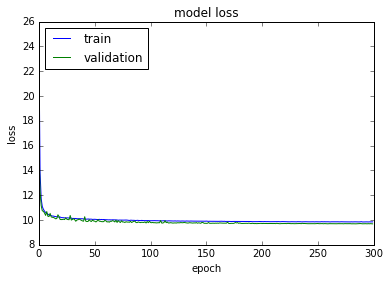

In [8]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


### Regression Results

In [9]:
# Setup matplotlib
plt.style.use('tdrstyle.mplstyle')

from nn_plotting import (gaus, fit_gaus, np_printoptions, \
                         find_efficiency_errors)

eps = 1e-7
my_cmap = plt.cm.viridis
my_cmap.set_under('w',1)
my_palette = ("#377eb8", "#e41a1c", "#984ea3", "#ff7f00", "#4daf4a")

In [10]:
# Load model and predict outputs
from nn_models import load_my_model, update_keras_custom_objects
update_keras_custom_objects()
#K.set_learning_phase(0)
loaded_model = load_my_model(name='model', weights_name='model_weights')
loaded_model.trainable = False
assert not loaded_model.updates
print(loaded_model.summary())
from keras.models import Model


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 23)                92        
_________________________________________________________________
dense_1 (Dense)              (None, 30)                690       
_________________________________________________________________
batch_normalization_2 (Batch (None, 30)                120       
_________________________________________________________________
activation_1 (Activation)    (None, 30)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 25)                750       
_________________________________________________________________
batch_normalization_3 (Batch (None, 25)                100       
_________________________________________________________________
activation_2 (Activation)    (None, 25)                0         
__________

In [11]:
# Predictions

y_test_true = y_test_displ.copy()
y_test_true /= reg_pt_scale

y_test_sel = (np.abs(1.0/y_test_displ) >= 20./reg_pt_scale)

y_test_meas_ = loaded_model.predict(x_test_displ, batch_size=4096)
y_test_meas = y_test_meas_[:,0]
y_test_meas /= reg_pt_scale
y_test_meas = y_test_meas.reshape(-1)

dxy_test_true = dxy_test_displ.copy()
dxy_test_true /= reg_dxy_scale

dxy_test_sel = (np.abs(dxy_test_true) >= 50)

dxy_test_meas = y_test_meas_[:,1]
dxy_test_meas /= reg_dxy_scale
dxy_test_meas = dxy_test_meas.reshape(-1)

print x_test_displ[1,:]
print y_test_meas[1]
print dxy_test_meas[1]
print y_test_true.shape, y_test_meas.shape, dxy_test_true.shape, dxy_test_meas.shape

[-14.   0. -22.   0.  -8.   0.   1.   0.   2.   0.   1.   0.  -1.  -0.
   0.  -0.   1.  42.   0.   0.   0.   0.   0.]
0.018955732
-0.06389284
(478800,) (478800,) (478800,) (478800,)


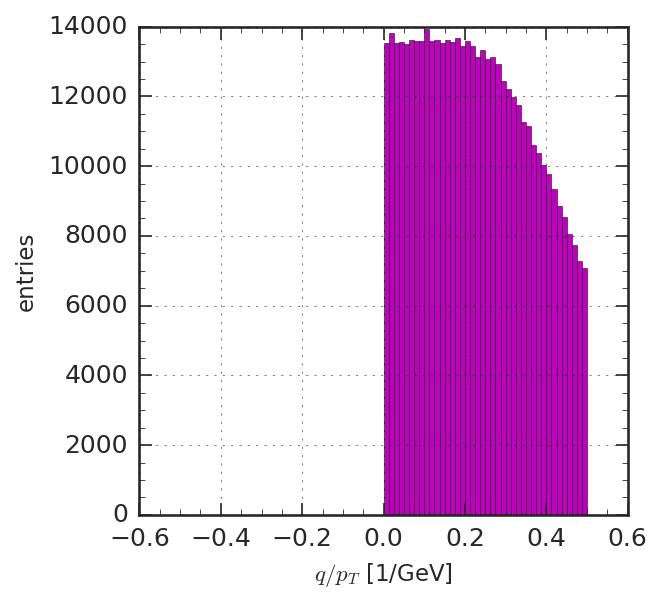

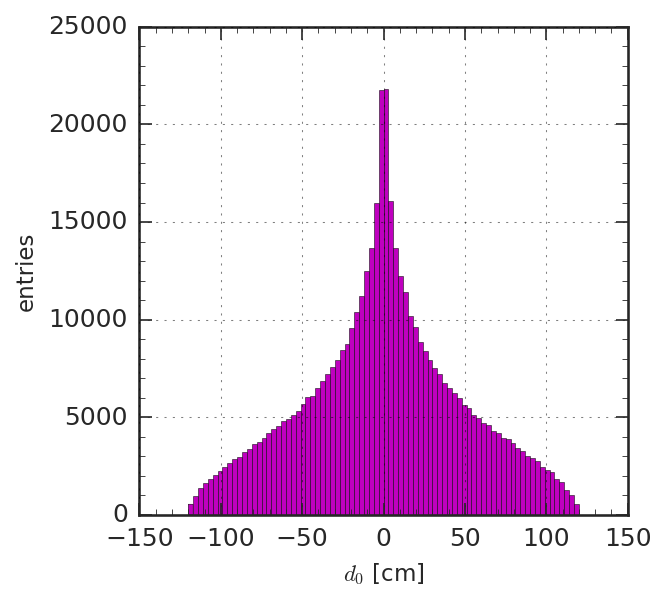

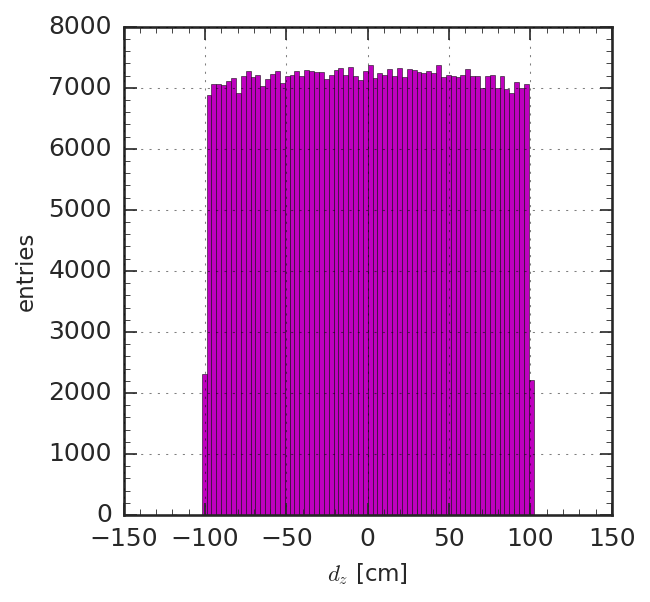

In [12]:
# Plot q/pT, d0, dz - displ

plt.figure()
plt.hist(y_test_displ/reg_pt_scale, bins=80, range=(-0.5,0.5), color='m')
plt.xlabel(r'$q/p_{T}$ [1/GeV]', fontsize=11)
plt.ylabel(r'entries', fontsize=11)

plt.figure()
plt.hist(dxy_test_displ/reg_dxy_scale, bins=80, range=(-120,120), color='m')
#plt.xlabel(r'$d_{xy}$ [cm]', fontsize=11)
plt.xlabel(r'$d_{0}$ [cm]', fontsize=11)
plt.ylabel(r'entries', fontsize=11)

plt.figure()
plt.hist(dz_test_displ, bins=80, range=(-120,120), color='m')
plt.xlabel(r'$d_{z}$ [cm]', fontsize=11)
plt.ylabel(r'entries', fontsize=11)

plt.show()


[INFO    ] # of entries: 54454, mean: 0.05664460361, std: 0.0696774944663
[INFO    ] gaus fit (a, mu, sig): [3.32470994e+03 2.32673368e-02 2.63337448e-02]


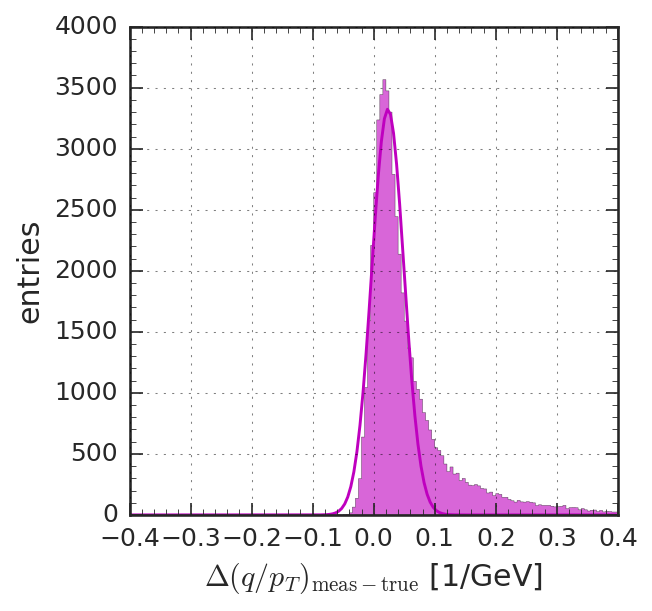

In [13]:
# Plot Delta(q/pT) - (b)

plt.figure()
yy = (y_test_meas - y_test_true)[y_test_sel]
hist, edges, _ = plt.hist(yy, bins=160, range=(-0.4,0.4-eps), histtype='stepfilled', facecolor='m', alpha=0.6)
plt.xlabel(r'$\Delta(q/p_{T})_{\mathrm{meas-true}}$ [1/GeV]')
plt.ylabel(r'entries')
logger.info('# of entries: {0}, mean: {1}, std: {2}'.format(len(yy), np.mean(yy), np.std(yy[np.abs(yy)<0.4])))

popt = fit_gaus(hist, edges, mu=np.mean(yy), sig=np.std(yy[np.abs(yy)<0.4]))
logger.info('gaus fit (a, mu, sig): {0}'.format(popt))
xdata = (edges[1:] + edges[:-1])/2
plt.plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='m')
plt.show()

[INFO    ] # of entries: 478800, mean: 0.0973241254687, std: 0.174027204514
[INFO    ] gaus fit (a, mu, sig): [ 1.95464427e+04 -2.52035011e-03  1.99868394e-01]


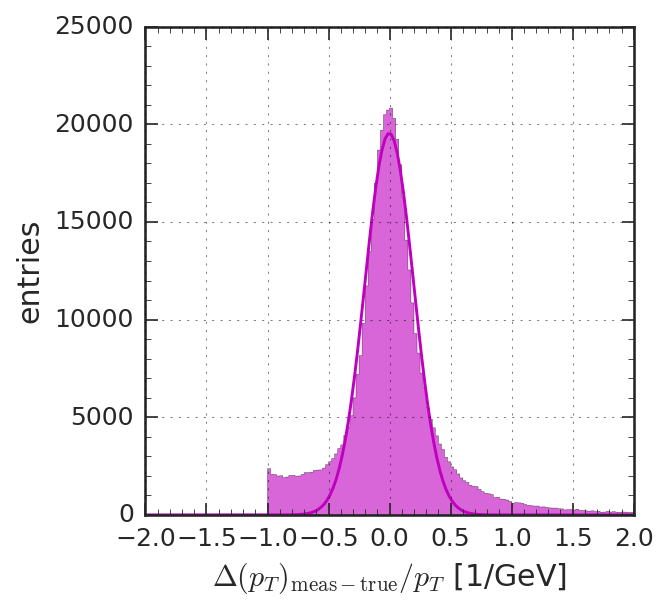

In [14]:
# Plot Delta(q/pT)/pT

plt.figure()
yy = ((np.abs(1.0/y_test_meas) - np.abs(1.0/y_test_true))/np.abs(1.0/y_test_true))
#yy = ((1.0/y_test_meas - 1.0/y_test_true)/y_test_true)[y_test_sel]
hist, edges, _ = plt.hist(yy, bins=160, range=(-2.0,2.0-eps), histtype='stepfilled', facecolor='m', alpha=0.6)
plt.xlabel(r'$\Delta(p_{T})_{\mathrm{meas-true}}/p_{T}$ [1/GeV]')
plt.ylabel(r'entries')
logger.info('# of entries: {0}, mean: {1}, std: {2}'.format(len(yy), np.mean(yy), np.std(yy[np.abs(yy)<0.4])))

popt = fit_gaus(hist, edges, mu=np.mean(yy), sig=np.std(yy[np.abs(yy)<2.0]))
logger.info('gaus fit (a, mu, sig): {0}'.format(popt))
xdata = (edges[1:] + edges[:-1])/2
plt.plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='m')
plt.show()

[INFO    ] # of entries: 54454, mean: 0.0184708777815, std: 9.32285308838
[INFO    ] gaus fit (a, mu, sig): [8.48279759e+03 2.44444949e-02 4.58176886e+00]


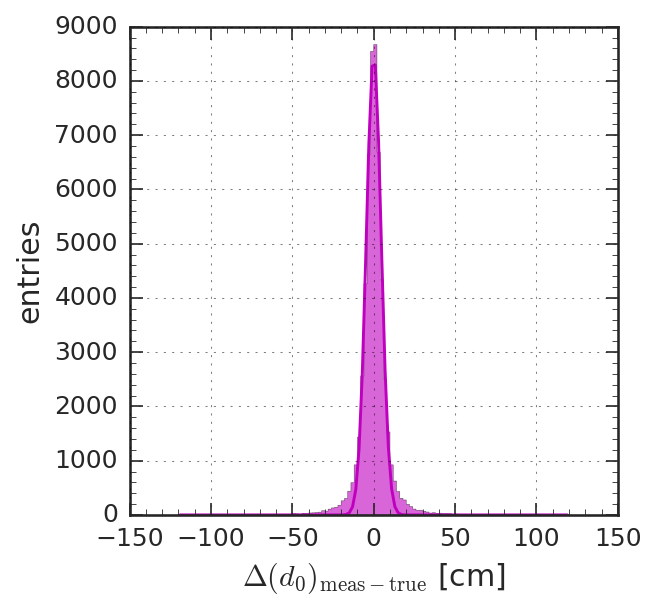

In [15]:


# Plot Delta(dxy) - (b)

plt.figure()
yy = (dxy_test_meas - dxy_test_true)[y_test_sel]
hist, edges, _ = plt.hist(yy, bins=120, range=(-120,120), histtype='stepfilled', facecolor='m', alpha=0.6)
#plt.xlabel(r'$\Delta(d_{xy})_{\mathrm{meas-true}}$ [cm]')
plt.xlabel(r'$\Delta(d_{0})_{\mathrm{meas-true}}$ [cm]')
plt.ylabel(r'entries')
logger.info('# of entries: {0}, mean: {1}, std: {2}'.format(len(yy), np.mean(yy), np.std(yy)))

popt = fit_gaus(hist, edges, mu=np.mean(yy), sig=np.std(yy))
logger.info('gaus fit (a, mu, sig): {0}'.format(popt))
xdata = (edges[1:] + edges[:-1])/2
plt.plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='m')
plt.show()


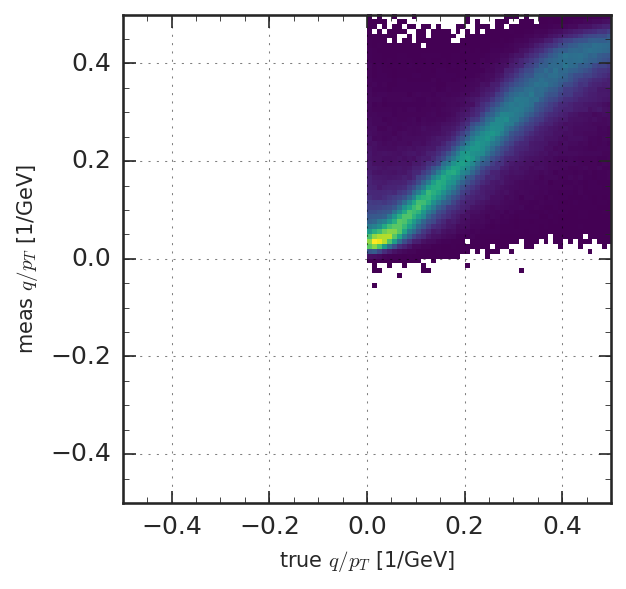

In [16]:
# Scatter plot - (a)

plt.figure()
plt.hist2d(y_test_true, y_test_meas, bins=(100,100), range=((-0.5,0.5),(-0.5,0.5)), vmin=1, cmap=my_cmap)
plt.xlabel(r'true $q/p_{T}$ [1/GeV]', fontsize=10)
plt.ylabel(r'meas $q/p_{T}$ [1/GeV]', fontsize=10)
plt.show()

In [17]:
# Make better resolution plot
xx = np.abs(y_test_true)
yy = ((y_test_meas) - (y_test_true))
#yy = ((y_test_meas) - (y_test_true))/np.abs(y_test_true)
#yy = (np.abs(1.0/y_test_meas) - np.abs(1.0/y_test_true))/np.abs(1.0/y_test_true)

nbinsx = 50
xedges = np.linspace(0, 0.5, num=nbinsx+1)
inds = np.digitize(xx, xedges[1:])

xxx0 = np.zeros(nbinsx, dtype=np.float32)
yyy0 = np.zeros(nbinsx, dtype=np.float32)
zzz0 = np.zeros(nbinsx, dtype=np.float32)
for i in xrange(nbinsx):
  xx_i = xx[inds==i]
  pt = np.mean(xx_i)
  pt = 1.0/pt
  
  yy_i = yy[inds==i] * pt
  #yy_i = yy[inds==i]
  yy_i = yy_i[(-1 <= yy_i) & (yy_i <= 1.5)]
  mu, sig = np.mean(yy_i), np.std(yy_i)
  assert(np.abs(mu) < 1)
  assert(np.abs(sig) < 2)
  
  hist, edges = np.histogram(yy_i, bins=100, range=(-0.6,0.6))  #FIXME
  #hist, edges = np.histogram(yy_i, bins=100, range=(-2,2))
  #popt = fit_gaus(hist, edges, mu=mu, sig=sig)
  popt = fit_gaus(hist, edges, mu=0.0, sig=0.2)
  #print i, len(xx_i), mu, sig, pt, popt
  
  if 20. < pt < 24.:
    xx0_20GeV, yy0_20GeV, popt_20GeV = xx_i, yy_i, popt
  
  xxx0[i] = pt
  yyy0[i] = popt[2]
  zzz0[i] = popt[1]

[INFO    ] gaus fit (a, mu, sig): [2.76543869e+02 1.84621201e-01 5.06049160e-01]
/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-matplotlib/1.5.2-omkpbe3/lib/python2.7/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


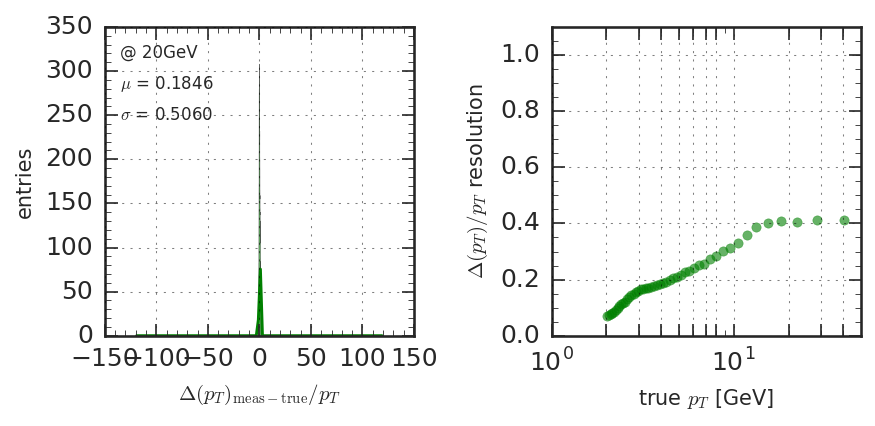

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(6,6/2), tight_layout=True)

#axs[0].hist2d(xx, yy, bins=(100,100), range=((0,0.5),(-1,3)), vmin=1, cmap=my_cmap)
#axs[0].set_xlabel(r'true $1/p_{T}$ [1/GeV]', fontsize=10)
#axs[0].set_ylabel(r'$\Delta(p_{T})_{\mathrm{meas-true}} / p_{T}$', fontsize=10)

hist, edges, _ = axs[0].hist(yy0_20GeV, bins=100, range=(-2.0,2.0), histtype='stepfilled', facecolor='g', alpha=0.6)
popt = fit_gaus(hist, edges, mu=0.0, sig=1)
axs[0].plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='g')
#hist, edges, _ = axs[0].hist(yy_20GeV, bins=100, range=(-1,1), histtype='stepfilled', facecolor='m', alpha=0.6)
#popt = fit_gaus(hist, edges, mu=0.0, sig=0.2)
#axs[0].plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]), color='m')
axs[0].text(0.05, 0.9, r'@ 20GeV', transform=axs[0].transAxes, fontsize=8)
axs[0].text(0.05, 0.8, r'$\mu$ = {0:.4f}'.format(popt[1]), transform=axs[0].transAxes, fontsize=8)
axs[0].text(0.05, 0.7, r'$\sigma$ = {0:.4f}'.format(popt[2]), transform=axs[0].transAxes, fontsize=8)
axs[0].set_xlabel(r'$\Delta(p_{T})_{\mathrm{meas-true}} / p_{T}$', fontsize=10)
axs[0].set_ylabel(r'entries', fontsize=10)
logger.info('gaus fit (a, mu, sig): {0}'.format(popt))

axs[1].scatter(xxx0, yyy0, color='g', alpha=0.6)

axs[1].set_xlim(1,50)
axs[1].set_ylim(0,1.1+eps)
axs[1].set_xlabel(r'true $p_{T}$ [GeV]', fontsize=10)
axs[1].set_ylabel(r'$\Delta(p_{T}) / p_{T}$ resolution', fontsize=10)
axs[1].set_xscale('log')
axs[1].set_xticks(range(1,9) + range(10,50,10))

plt.show()

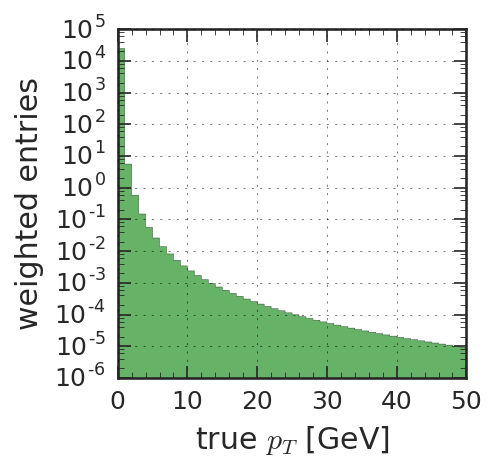

In [19]:
# Mock minbias pT spectrum
xx = np.linspace(0.1, 49.1, num=50)
#reweight = lambda x: 5.5 * np.power(x,-3)
#reweight = lambda x: 11 * np.power(x,-4)
reweight = lambda x: 7.778 * np.power(x,-3.5)
xw = np.fromiter((reweight(xi) for xi in xx), xx.dtype)

plt.figure(figsize=(3,3))
plt.hist(xx, bins=50, range=(0,50), weights=xw, histtype='stepfilled', facecolor='g', alpha=0.6)
plt.xlabel(r'true $p_{T}$ [GeV]')
plt.ylabel(r'weighted entries')
plt.yscale('log')
plt.show()

In [20]:
# Predict 20 GeV rates with 90% coverage
xx = np.abs(1.0/y_test_true)
yy = np.abs(1.0/y_test_meas)

reweight = lambda x, y, thresh: 7.778 * np.power(x,-2.5) if y >= thresh else 0.  # -2.5 instead of -3.5 because the parent distribution is already 1/pT-weighted

nbinsx = 20
xedges = np.linspace(2, 42, num=nbinsx+1)
inds = np.digitize(xx, xedges[1:])

xxx = np.zeros(nbinsx, dtype=np.float32)
for i in xrange(nbinsx):
  xx_i = xx[inds==i]
  yy_i = yy[inds==i]
  pct = np.percentile(yy_i, [10, 50, 90], overwrite_input=True)
  #print np.mean(xx_i), len(xx_i), pct
  
  xxx[i] = pct[0]

ind_20GeV = np.digitize(20., xedges[1:])
thresh_20GeV = xxx[ind_20GeV]
yw = np.fromiter((reweight(xi, yi, thresh_20GeV) for (xi, yi) in zip(xx, yy)), xx.dtype)
logger.info("20 GeV threshold {0} rate {1}".format(thresh_20GeV, np.sum(yw)))

ind_22GeV = np.digitize(22., xedges[1:])
thresh_22GeV = xxx[ind_22GeV]
yw = np.fromiter((reweight(xi, yi, thresh_22GeV) for (xi, yi) in zip(xx, yy)), xx.dtype)
logger.info("22 GeV threshold {0} rate {1}".format(thresh_22GeV, np.sum(yw)))

[INFO    ] 20 GeV threshold 6.45383405685 rate 8302.76757812
[INFO    ] 22 GeV threshold 6.61696577072 rate 7735.36572266


### Classification Results

In [20]:
# Prepare y_test_true, y_test_meas (again)
y_test_true = [y_test[0][:nentries_test].copy(), y_test[1][:nentries_test].copy()]
y_test_meas = loaded_model.predict(x_test[:nentries_test], batch_size=4096)

y_test_sel = (y_test_true[1] != mask_value)  # skip low pT muons
y_test_true[0] /= reg_pt_scale
y_test_meas[0] /= reg_pt_scale
#print y_test_true[0].shape, y_test_true[0], y_test_true[1].shape, y_test_true[1]
#print y_test_meas[0].shape, y_test_meas[0], y_test_meas[1].shape, y_test_meas[1]

# Prepare pu_y_test_true, pu_y_test_meas
pu_y_test_sel = ~(pu_aux_test[:,2] > discr_pt_cut)  # veto PU events with high-pT tracks
pu_y_test_true = [pu_y_test[0].copy(), pu_y_test[1].copy()]
pu_y_test_meas = loaded_model.predict(pu_x_test, batch_size=4096)
#pu_y_test_true[0] /= reg_pt_scale
pu_y_test_meas[0] /= reg_pt_scale
#print pu_y_test_true[0].shape, pu_y_test_true[0], pu_y_test_true[1].shape, pu_y_test_true[1]
#print pu_y_test_meas[0].shape, pu_y_test_meas[0], pu_y_test_meas[1].shape, pu_y_test_meas[1]

In [21]:
def roc_singlemu(x_mask):
  valid = ~x_mask
  mode = np.int32(0)
  if np.any([valid[0], valid[1], valid[5], valid[9], valid[11]]):   # ME1/1, ME1/2, RE1/2, GE1/1, ME0
    mode |= (1<<3)
  if np.any([valid[2], valid[6], valid[10]]):  # ME2, RE2, GE2/1
    mode |= (1<<2)
  if np.any([valid[3], valid[7]]):  # ME3, RE3
    mode |= (1<<1)
  if np.any([valid[4], valid[8]]):  # ME4, RE4
    mode |= (1<<0)
  return mode in (11,13,14,15)

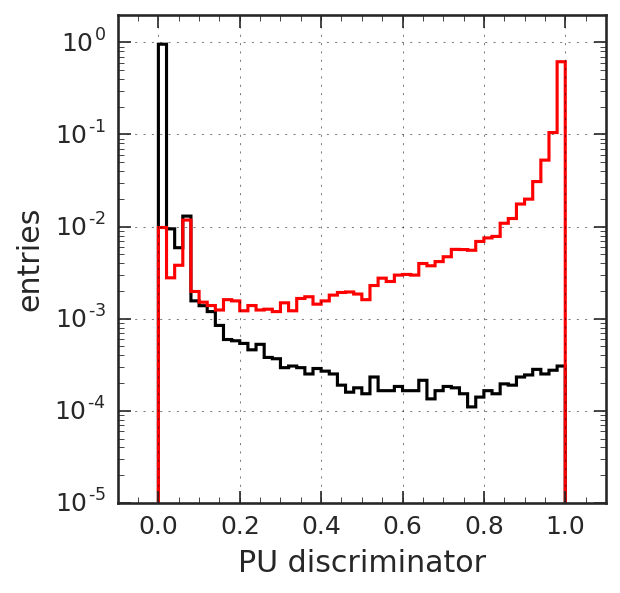

In [22]:
# Plot discriminator
plt.figure()
xx = pu_y_test_meas[1][pu_y_test_sel]
xw = np.ones_like(xx)/float(len(xx))
yy = y_test_meas[1][y_test_sel]
yw = np.ones_like(yy)/float(len(yy))
plt.hist(xx, bins=50, range=(0,1), weights=xw, histtype='step', color='black', lw=1.5)
plt.hist(yy, bins=50, range=(0,1), weights=yw, histtype='step', color='red', lw=1.5)
plt.xlabel(r'PU discriminator')
plt.ylabel(r'entries')
plt.xlim(-0.1, 1.1)
plt.ylim(1e-5, 2)
plt.yscale('log')
plt.show()

# Calculate separation score?

In [23]:
# Plot ROC
from sklearn.metrics import roc_curve, roc_auc_score

xx = np.concatenate((y_test_true[1][y_test_sel], pu_y_test_true[1][pu_y_test_sel]))
yy = np.concatenate((y_test_meas[1][y_test_sel], pu_y_test_meas[1][pu_y_test_sel]))
zz = np.concatenate((y_test_meas[0][y_test_sel], pu_y_test_meas[0][pu_y_test_sel]))
tt = np.concatenate((x_mask_test[:nentries_test][y_test_sel], pu_x_mask_test[pu_y_test_sel]))

tt = np.apply_along_axis(roc_singlemu, 1, tt)  # require SingleMu quality
xx = xx[:, np.newaxis]
xx = xx[tt]
yy = yy[tt]
zz = zz[tt]


[INFO    ] auc: 0.982649011871
[INFO    ] thr: [0.9282, 0.8991, 0.8243, 0.6435, 0.5519, 0.3914, 0.1411, 0.0705, 0.0509]
[INFO    ] tpr: [0.9004, 0.9252, 0.9501, 0.9700, 0.9751, 0.9800, 0.9850, 0.9900, 0.9990]
[INFO    ] fpr: [0.0366, 0.0445, 0.0554, 0.0788, 0.0885, 0.1086, 0.1668, 0.2762, 0.6831]
[INFO    ] auc: 0.987131938174
[INFO    ] thr: [0.9447, 0.9051, 0.7987, 0.6065, 0.5181, 0.3055, 0.0720, 0.0704, 0.0549]
[INFO    ] tpr: [0.9012, 0.9259, 0.9510, 0.9702, 0.9750, 0.9800, 0.9850, 0.9900, 0.9990]
[INFO    ] fpr: [0.0180, 0.0246, 0.0331, 0.0545, 0.0652, 0.0885, 0.1818, 0.2766, 0.7120]


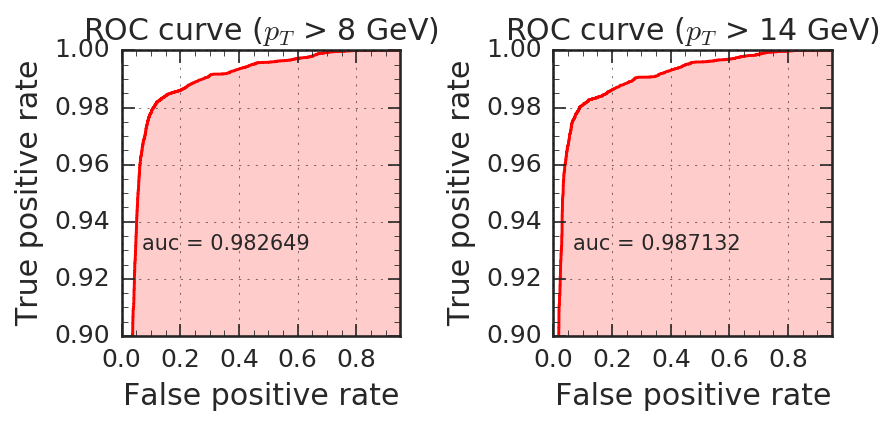

In [24]:
# Plot ROC

fig, axs = plt.subplots(1, 2, figsize=(6,6/2), tight_layout=True)

working_points = [0.9, 0.925, 0.95, 0.97, 0.975, 0.98, 0.985, 0.99, 0.999]

# pT > 8 GeV, corresponding to 10 GeV trigger threshold
zzz = np.abs(1.0/zz) > discr_pt_cut
xxx = xx[zzz]
yyy = yy[zzz]
fpr, tpr, thresh = roc_curve(xxx, yyy)  # (y_true, y_meas)
auc = roc_auc_score(xxx, yyy)           # (y_true, y_meas)

idx = np.searchsorted(tpr, working_points)
logger.info("auc: {0}".format(auc))
logger.info("thr: {0}".format(np.array2string(thresh[idx], separator=', ', precision=4, floatmode='fixed')))
logger.info("tpr: {0}".format(np.array2string(tpr[idx], separator=', ', precision=4, floatmode='fixed')))
logger.info("fpr: {0}".format(np.array2string(fpr[idx], separator=', ', precision=4, floatmode='fixed')))

axs[0].plot(fpr, tpr, color='r')
axs[0].fill_between(fpr, tpr, color='r', alpha=0.2)
axs[0].set_title(r'ROC curve ($p_{T}$ > 8 GeV)')
axs[0].set_xlabel('False positive rate')
axs[0].set_ylabel('True positive rate')
axs[0].text(0.068, 0.93, 'auc = %f' % auc, fontsize=10)
axs[0].set_xlim(0.0,0.95)
axs[0].set_ylim(0.9,1.0)

# pT > 14 GeV, corresponding to 20 GeV trigger threshold
zzz = np.abs(1.0/zz) > discr_pt_cut_high
xxx = xx[zzz]
yyy = yy[zzz]
fpr, tpr, thresh = roc_curve(xxx, yyy)  # (y_true, y_meas)
auc = roc_auc_score(xxx, yyy)           # (y_true, y_meas)

idx = np.searchsorted(tpr, working_points)
logger.info("auc: {0}".format(auc))
logger.info("thr: {0}".format(np.array2string(thresh[idx], separator=', ', precision=4, floatmode='fixed')))
logger.info("tpr: {0}".format(np.array2string(tpr[idx], separator=', ', precision=4, floatmode='fixed')))
logger.info("fpr: {0}".format(np.array2string(fpr[idx], separator=', ', precision=4, floatmode='fixed')))

axs[1].plot(fpr, tpr, color='r')
axs[1].fill_between(fpr, tpr, color='r', alpha=0.2)
axs[1].set_title(r'ROC curve ($p_{T}$ > 14 GeV)')
axs[1].set_xlabel('False positive rate')
axs[1].set_ylabel('True positive rate')
axs[1].text(0.068, 0.93, 'auc = %f' % auc, fontsize=10)
axs[1].set_xlim(0.0,0.95)
axs[1].set_ylim(0.9,1.0)

plt.show()

### Efficiency & Rates 

In [24]:
# Build track producer

from six.moves import range, zip, map, filter

pt_bins = (-0.5, -0.365, -0.26, -0.155, -0.07, 0.07, 0.155, 0.26, 0.365, 0.5)

theta_to_eta_lut = [
   2.599, 2.566, 2.534, 2.503, 2.473, 2.444, 2.415, 2.388, 2.361, 2.334,
   2.309, 2.284, 2.259, 2.236, 2.212, 2.19 , 2.167, 2.145, 2.124, 2.103,
   2.083, 2.063, 2.043, 2.024, 2.005, 1.986, 1.968, 1.95 , 1.932, 1.915,
   1.898, 1.881, 1.864, 1.848, 1.832, 1.816, 1.8  , 1.785, 1.77 , 1.755,
   1.74 , 1.726, 1.711, 1.697, 1.683, 1.67 , 1.656, 1.642, 1.629, 1.616,
   1.603, 1.59 , 1.578, 1.565, 1.553, 1.541, 1.529, 1.517, 1.505, 1.493,
   1.482, 1.47 , 1.459, 1.448, 1.436, 1.425, 1.415, 1.404, 1.393, 1.382,
   1.372, 1.362, 1.351, 1.341, 1.331, 1.321, 1.311, 1.301, 1.291, 1.282,
   1.272, 1.262, 1.253, 1.244, 1.234, 1.225, 1.216, 1.207, 1.198, 1.189,
]

def find_pt_bin(pt):
  ipt = np.digitize((pt,), pt_bins[1:])[0]  # skip lowest edge
  ipt = np.clip(ipt, 0, len(pt_bins)-2)
  return ipt

def find_emtf_road_quality(ipt):
  best_ipt = find_pt_bin(0.)
  return best_ipt - np.abs(ipt - best_ipt)

nvariables = nvariables

discr_pt_cut = discr_pt_cut

def get_theta_median_from_x(x):
  assert(x.shape[0] == nvariables)
  theta_median = x[-1] # last variable
  theta_median = (theta_median * 83) + 3
  return theta_median.astype(np.int32)

def get_zone_from_x(x):
  assert(x.shape[0] == nvariables)
  zone = x[-2] # second last variable
  zone = (zone * 5) + 0
  return zone.astype(np.int32)

def get_straightness_from_x(x):
  assert(x.shape[0] == nvariables)
  straightness = x[-3] # third last variable
  straightness = (straightness * 4) + 4
  return straightness.astype(np.int32)

def get_ndof_from_x_mask(x_mask):
  assert(x_mask.shape[0] == nlayers)
  assert(x_mask.dtype == np.bool)
  valid = ~x_mask
  return valid.sum()

def get_mode_from_x_mask(x_mask):
  assert(x_mask.shape[0] == nlayers)
  assert(x_mask.dtype == np.bool)
  valid = ~x_mask
  mode = np.int32(0)
  if np.any([valid[0], valid[1], valid[5], valid[9], valid[11]]):   # ME1/1, ME1/2, RE1/2, GE1/1, ME0
    mode |= (1<<3)
  if np.any([valid[2], valid[6], valid[10]]):  # ME2, RE2, GE2/1
    mode |= (1<<2)
  if np.any([valid[3], valid[7]]):  # ME3, RE3
    mode |= (1<<1)
  if np.any([valid[4], valid[8]]):  # ME4, RE4
    mode |= (1<<0)

  # Apply modified SingleMu requirement
  mode_me0 = np.int32(0)
  if valid[11]: # ME0
    mode_me0 |= (1 << 2)
  if valid[0]:  # ME1/1
    mode_me0 |= (1 << 1)
  if np.any([valid[2], valid[3], valid[4]]):  # ME2, ME3, ME4
    mode_me0 |= (1 << 0)
  if mode not in (11,13,14,15) and mode_me0 == 7:
    mode = 11  # pretend as mode 11
  return mode

class TrackProducer(object):
  def __init__(self):
    self.s_min = 0.
    self.s_max = 60.
    self.s_nbins = 120
    self.s_step = (self.s_max - self.s_min)/self.s_nbins
    self.s_lut =[ 1.8005,  1.5194,  1.5708,  1.8247,  2.1989,  2.6489,  3.1625,  3.7251,
                  4.3240,  4.9595,  5.6337,  6.3424,  7.0590,  7.7485,  8.4050,  9.0398,
                  9.6598, 10.2800, 10.9236, 11.6060, 12.3216, 13.0521, 13.7887, 14.5427,
                 15.2964, 16.0232, 16.7303, 17.4535, 18.2066, 19.0044, 19.8400, 20.6934,
                 21.5215, 22.3143, 23.1066, 23.8221, 24.4586, 25.1335, 25.9083, 26.7333,
                 27.5310, 28.2623, 28.9778, 29.7226, 30.5507, 31.4670, 32.4541, 33.5263,
                 34.5659, 35.5155, 36.4457, 37.4019, 38.3762, 39.3604, 40.3595, 41.3763,
                 42.3333, 43.2434, 44.2686, 45.5962, 47.0878, 48.3783, 49.4891, 50.5445,
                 51.4431, 52.2846, 53.1180, 53.9492, 54.7793, 55.6090, 56.4384, 57.2676,
                 58.0967, 58.9257, 59.7547, 60.5836, 61.4125, 62.2413, 63.0702, 63.8990,
                 64.7278, 65.5566, 66.3854, 67.2142, 68.0430, 68.8718, 69.7006, 70.5293,
                 71.3581, 72.1869, 73.0157, 73.8444, 74.6732, 75.5020, 76.3307, 77.1595,
                 77.9882, 78.8170, 79.6458, 80.4745, 81.3033, 82.1321, 82.9608, 83.7896,
                 84.6183, 85.4471, 86.2759, 87.1046, 87.9334, 88.7621, 89.5909, 90.4197,
                 91.2484, 92.0772, 92.9059, 93.7347, 94.5635, 95.3922, 96.2210, 97.0497]
    #self.s_lut = np.linspace(self.s_min, self.s_max, num=self.s_nbins+1)[:-1]
    self.s_step = np.asarray(self.s_step)
    self.s_lut = np.asarray(self.s_lut)

  def get_trigger_pt(self, x, y_meas):
    xml_pt = np.abs(1.0/y_meas)
    if xml_pt <= 2.:  # do not use the LUT if below 2 GeV
      return xml_pt

    def digitize(x, bins=(self.s_nbins, self.s_min, self.s_max)):
      x = np.clip(x, bins[1], bins[2]-1e-5)
      binx = (x - bins[1]) / (bins[2] - bins[1]) * bins[0]
      return binx.astype(np.int32)

    def interpolate(x, x0, x1, y0, y1):
      y = (x - x0) / (x1 - x0) * (y1 - y0) + y0
      return y

    binx = digitize(xml_pt)
    if binx == self.s_nbins-1:  # check boundary
      binx -= 1

    x0, x1 = binx * self.s_step, (binx+1) * self.s_step
    y0, y1 = self.s_lut[binx], self.s_lut[binx+1]
    pt = interpolate(xml_pt, x0, x1, y0, y1)
    return pt

  def pass_trigger(self, strg, ndof, mode, theta_median, y_meas, y_discr, discr_pt_cut=14.):
    ipt1 = strg
    ipt2 = find_pt_bin(y_meas)
    quality1 = find_emtf_road_quality(ipt1)
    quality2 = find_emtf_road_quality(ipt2)

    if mode in (11,13,14,15) and quality2 <= (quality1+1):
      if np.abs(1.0/y_meas) > 14:
        trigger = (y_discr > 0.9136) # 98.0% coverage
      elif np.abs(1.0/y_meas) > discr_pt_cut:
        trigger = (y_discr > 0.7415) # 98.0% coverage
      else:
        trigger = (y_discr >= 0.)  # True
    else:
      trigger = (y_discr < 0.)  # False
    return trigger

  def run(self, slim_roads, variables, predictions, other_vars):
    assert(len(slim_roads) == len(variables))
    assert(len(slim_roads) == len(predictions))
    assert(len(slim_roads) == len(other_vars))

    tracks = []

    for myroad, myvars, mypreds, myother in zip(slim_roads, variables, predictions, other_vars):
      assert(len(myvars.shape) == 1)
      x = myvars
      x_mask = myother
      y_meas = np.asscalar(mypreds[...,0])
      y_discr = np.asscalar(mypreds[...,1])

      theta_median = get_theta_median_from_x(x)
      zone = get_zone_from_x(x)
      strg = get_straightness_from_x(x)
      ndof = get_ndof_from_x_mask(x_mask)
      mode = get_mode_from_x_mask(x_mask)

      passed = self.pass_trigger(strg, ndof, mode, theta_median, y_meas, y_discr, discr_pt_cut=discr_pt_cut)
      xml_pt = np.abs(1.0/y_meas)
      pt = self.get_trigger_pt(x, y_meas)

      if passed:
        trk_q = np.sign(y_meas)
        trk_emtf_phi = myroad.id[4]
        trk_emtf_theta = myroad.theta_median
        trk = Track(myroad.id, myroad.hits, mode, xml_pt, pt, trk_q, trk_emtf_phi, trk_emtf_theta, ndof, y_discr)
        tracks.append(trk)
    return tracks

mytrigger = TrackProducer()

In [25]:
# Efficiency
eff_data = []

for ievt, (x, x_mask, y_meas, y_discr, y_true) in enumerate(zip(x_test, x_mask_test, y_test_meas[0], y_test_meas[1], y_test_true[0])):
  theta_median = get_theta_median_from_x(x)
  zone = get_zone_from_x(x)
  strg = get_straightness_from_x(x)
  ndof = get_ndof_from_x_mask(x_mask)
  mode = get_mode_from_x_mask(x_mask)
  
  passed = mytrigger.pass_trigger(strg, ndof, mode, theta_median, y_meas, y_discr, discr_pt_cut=discr_pt_cut)
  xml_pt = np.abs(1.0/y_meas)
  pt = mytrigger.get_trigger_pt(x, y_meas)
  pt_true = np.abs(1.0/y_true)
  
  eff_data.append((zone, pt_true, xml_pt, pt, passed, theta_median))
  
  # Debug
  if ievt < 20.:
    print ievt, ndof, float(y_discr), float(pt_true), float(xml_pt), float(pt), passed
  
eff_data = np.asarray(eff_data)

0 12 0.0328128859401 5.92012103328 5.20848369598 5.92920479069 [ True]
1 12 0.000293385703117 3.1666473673 3.1693854332 3.35309248943 [ True]
2 12 0.0358576253057 4.54122276607 5.02364635468 5.66721634312 [False]
3 12 3.07715781673e-05 2.21765639947 2.15925884247 2.34223295822 [ True]
4 12 0.00564367417246 3.89396537138 4.00781106949 4.33392786932 [False]
5 12 0.979321241379 14.2182236602 17.2156486511 23.4151932198 [ True]
6 12 0.000130615022499 3.17920281999 2.65164756775 2.80467238159 [ True]
7 12 0.00412418367341 4.42436284899 4.08649969101 4.43394110727 [ True]
8 12 0.0450778268278 5.40970385582 4.8683962822 5.45624554691 [ True]
9 12 6.20531573077e-05 3.76643593606 3.58355665207 3.82518415785 [ True]
10 12 0.000217535096454 2.89595154569 2.96518778801 3.12674089584 [ True]
11 12 0.00847681891173 3.94286688583 4.21649932861 4.59917064667 [ True]
12 12 9.38497748848e-07 2.60116675021 2.24926662445 2.42323996201 [ True]
13 12 3.6502689909e-05 2.06544204286 2.36603546143 2.5283319152

/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-pippkgs/6.0-omkpbe5/lib/python2.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-numpy/1.14.1-omkpbe2/lib/python2.7/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-numpy/1.14.1-omkpbe2/lib/python2.7/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-pippkgs/6.0-omkpbe5/lib/python2.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


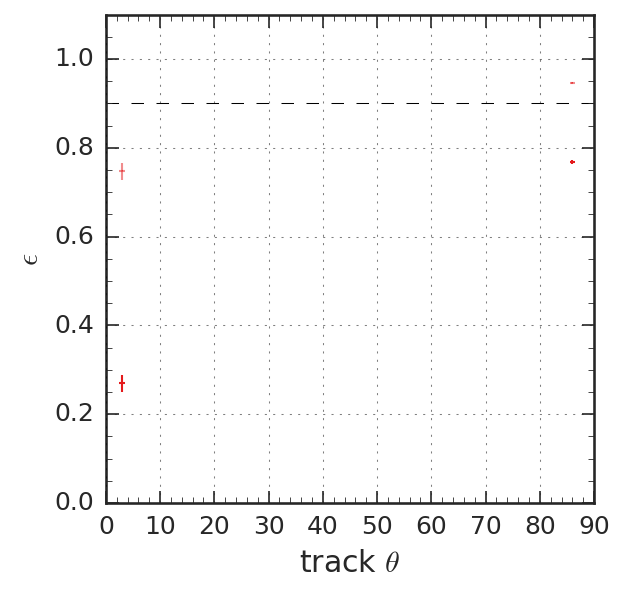

In [26]:
# Efficiency
plt.figure()

pt = 20
color = my_palette[1]
gen_passed = eff_data[:, 1] > 30  # index 1 is pt_true
passed = gen_passed & (eff_data[:, 3] > pt) & (eff_data[:, 4] == 1)  # index 3 is pt, index 4 is passed

denom_hist, edges = np.histogram(eff_data[:, 5][gen_passed], bins=89, range=(0.5,89.5))  # index 5 is theta_median
num_hist, edges = np.histogram(eff_data[:, 5][passed], bins=89, range=(0.5,89.5))  # index 1 is pt_true
eff_hist = np.true_divide(num_hist, denom_hist)

xdata = (edges[1:] + edges[:-1])/2
xerr = (edges[1:] - edges[:-1])/2
yerr = find_efficiency_errors(denom_hist, num_hist)
ydata = eff_hist
#print pt, ydata

plt.errorbar(xdata, ydata, xerr=xerr, yerr=yerr, color=color, marker=',', capsize=0, lw=1)

passed = gen_passed & (eff_data[:, 3] > pt) & (eff_data[:, 4] >= 0)  # index 3 is pt, index 4 is passed
num_hist, edges = np.histogram(eff_data[:, 5][passed], bins=89, range=(0.5,89.5))  # index 1 is pt_true
eff_hist = np.true_divide(num_hist, denom_hist)
yerr = find_efficiency_errors(denom_hist, num_hist)
ydata = eff_hist

plt.errorbar(xdata, ydata, xerr=xerr, yerr=yerr, color=color, alpha=0.5, marker=',', capsize=0, lw=1)
  
plt.plot([0,90], [0.9,0.9], ls='dashed', lw=0.5, color='black')
plt.xlim(0,90)
plt.ylim(0,1.1)
plt.xlabel(r'track $\theta$')
plt.ylabel(r'$\epsilon$')
plt.show()

## Efficiency
eff_pt_bins = (0., 0.5, 1., 1.5, 2., 3., 4., 5., 6., 7., 8., 10., 12., 14., 16., 18., 20., 22., 24., 27., 30., 34., 40., 48., 60., 80., 120.)

pt_list = (10., 20., 30., 40., 50., 60.)

plt.figure()

denom_hist, edges = np.histogram(eff_data[:, 1], bins=eff_pt_bins)  # index 1 is pt_true

for pt, color in zip(pt_list, my_palette):
  passed = (eff_data[:, 3] > pt) & (eff_data[:, 4] == 1)  # index 3 is pt, index 4 is passed
  num_hist, edges = np.histogram(eff_data[:, 1][passed], bins=eff_pt_bins)  # index 1 is pt_true
  eff_hist = np.true_divide(num_hist, denom_hist)
  
  xdata = (edges[1:] + edges[:-1])/2
  xerr = (edges[1:] - edges[:-1])/2
  yerr = find_efficiency_errors(denom_hist, num_hist)
  ydata = eff_hist
  print pt, ydata
  
  plt.errorbar(xdata, ydata, xerr=xerr, yerr=yerr, color=color, marker=',', capsize=0, lw=1)

plt.plot([0,120], [0.9,0.9], ls='dashed', lw=0.5, color='black')
plt.xlim(0,120)
plt.ylim(0,1.1)
plt.xlabel(r'true $p_{T}$ [GeV]')
plt.ylabel(r'$\epsilon$')
plt.show()

In [31]:
# Find out pT scale factor

nbinsx = 120
xedges = np.linspace(0, 60, num=nbinsx+1)  # 0.5GeV step size

xxx = np.zeros((4,nbinsx), dtype=np.float32)

for j in xrange(4):  # j = zone0-1, zone2-4, zone5-6, all zones
  if j == 0:
    eff_data_tmp = np.logical_or(eff_data[:,0]==0, eff_data[:,0]==1)
  elif j == 1:
    eff_data_tmp = np.logical_or(eff_data[:,0]==2, eff_data[:,0]==3, eff_data[:,0]==4)
  elif j == 2:
    eff_data_tmp = np.logical_or(eff_data[:,0]==5, eff_data[:,0]==6)
  elif j == 3:
    eff_data_tmp = (eff_data[:,0] >= 0)
    
  xx = eff_data[:,1][eff_data_tmp]  # pt_true
  yy = eff_data[:,2][eff_data_tmp]  # xml_pt
  zz = eff_data[:,4][eff_data_tmp]  # discr_passed
  
  ind = np.digitize(xx, xedges[1:])
  
  for i in xrange(nbinsx):  # i = pT in 0.5GeV step
    if xedges[i] <= 2:  # ignore below 2 GeV
      xxx[j,i] = xedges[i]
      continue
    
    if xedges[i] <= 24:
      step = 4  # 2GeV step size
    elif xedges[i] <= 32:
      step = 8  # 4GeV step size
    elif xedges[i] <= 36:
      step = 12 # 6GeV step size
    else:
      step = 16 # 8GeV step size
    xx_i = xx[(i <= ind) & (ind <= i+step)]
    yy_i = yy[(i <= ind) & (ind <= i+step)]
    zz_i = zz[(i <= ind) & (ind <= i+step)]
    coverage = 90  
    coverage += 1.0 # inefficiency due to fiducial cuts
    #coverage += 1.5 # inefficiency due to fiducial cuts
    #pct = np.percentile(yy_i, 100-coverage, overwrite_input=True)
    
    yz_i = np.where(zz_i==0, 0, yy_i)
    pct = np.percentile(yz_i, 100-coverage, overwrite_input=True)
    
    xxx[j,i] = pct
    
    # Debug
    if j == 3 and 14 <= xedges[i] <= 30:
      print xedges[i], 100. * (zz_i==0).sum() / (zz_i>=0).sum()
    #print np.mean(xx_i), len(xx_i), pct
    #if xedges[i] == 20:
    #  print i, coverage, np.percentile(yy_i, [1,2,3,4,5,6,7,8,9,10,11,12], overwrite_input=True)
    #  print i, coverage, np.percentile(yy_i[zz_i==1], [1,2,3,4,5,6,7,8,9,10,11,12], overwrite_input=True)

#print np.array2string(xxx, separator=', ', precision=4, floatmode='fixed')

14.0 2.23699140866
14.5 2.37929836749
15.0 2.27314390467
15.5 2.10116731518
16.0 2.00245198202
16.5 2.00907323396
17.0 2.05011389522
17.5 2.10297316896
18.0 2.24400309518
18.5 2.37575095576
19.0 2.42027334852
19.5 2.20264317181
20.0 2.12307692308
20.5 2.21366698749
21.0 2.1650879567
21.5 1.97557471264
22.0 1.9120458891
22.5 1.77304964539
23.0 1.93734542457
23.5 1.88758389262
24.0 1.98325253416
24.5 1.78671133445
25.0 1.87373882963
25.5 1.66567519334
26.0 1.58779576588
26.5 1.88197767145
27.0 2.13464696223
27.5 2.11196781763
28.0 2.05690778197
28.5 1.97391610857
29.0 1.96578085184
29.5 1.92670948243
30.0 2.18579234973


[ 0.0000,  0.5000,  1.0000,  1.5000,  2.0000,  2.5000,  3.0000,  3.5000,
  4.0000,  4.5000,  5.0000,  5.5000,  6.0000,  6.5000,  7.0000,  7.5000,
  8.0000,  8.5000,  9.0000,  9.5000, 10.0000, 10.5000, 11.0000, 11.5000,
 12.0000, 12.5000, 13.0000, 13.5000, 14.0000, 14.5000, 15.0000, 15.5000,
 16.0000, 16.5000, 17.0000, 17.5000, 18.0000, 18.5000, 19.0000, 19.5000,
 20.0000, 20.5000, 21.0000, 21.5000, 22.0000, 22.5000, 23.0000, 23.5000,
 24.0000, 24.5000, 25.0000, 25.5000, 26.0000, 26.5000, 27.0000, 27.5000,
 28.0000, 28.5000, 29.0000, 29.5000, 30.0000, 30.5000, 31.0000, 31.5000,
 32.0000, 32.5000, 33.0000, 33.5000, 34.0000, 34.5000, 35.0000, 35.5000,
 36.0000, 36.5000, 37.0000, 37.5000, 38.0000, 38.5000, 39.0000, 39.5000,
 40.0000, 40.5000, 41.0000, 41.5000, 42.0000, 42.5000, 43.0000, 43.5000,
 44.0000, 44.5000, 45.0000, 45.5000, 46.0000, 46.5000, 47.0000, 47.5000,
 48.0000, 48.5000, 49.0000, 49.5000, 50.0000, 50.5000, 51.0000, 51.5000,
 52.0000, 52.5000, 53.0000, 53.5000, 54.0000, 54.50

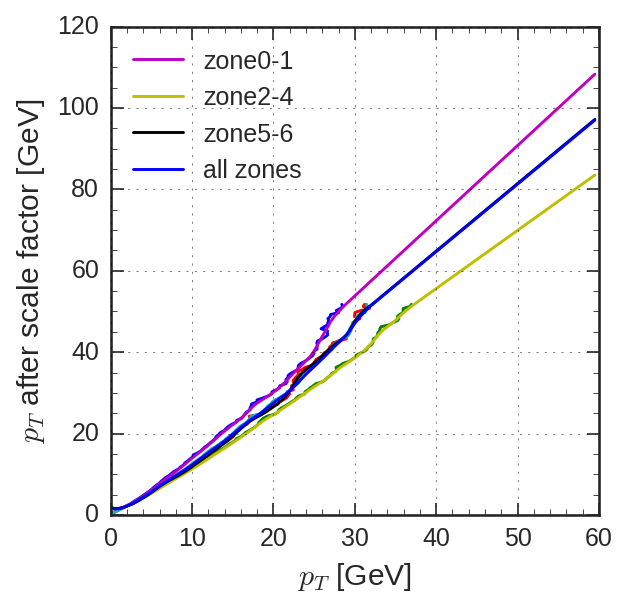

In [32]:
plt.figure()

xdata = (xedges[1:] + xedges[:-1])/2
plt.plot(xxx[0,:-16], xdata[:-16])
plt.plot(xxx[1,:-16], xdata[:-16])
plt.plot(xxx[2,:-16], xdata[:-16])
plt.plot(xxx[3,:-16], xdata[:-16])
plt.xlabel(r'$p_{T}$ [GeV]')
plt.ylabel(r'$p_{T}$ after scale factor [GeV]')

from scipy.interpolate import Rbf
rbf0 = Rbf(xxx[0,:-16], xedges[:-16-1], smooth = 10.0, function='multiquadric')
rbf1 = Rbf(xxx[1,:-16], xedges[:-16-1], smooth = 10.0, function='multiquadric')
rbf2 = Rbf(xxx[2,:-16], xedges[:-16-1], smooth = 10.0, function='multiquadric')
rbf3 = Rbf(xxx[3,:-16], xedges[:-16-1], smooth = 10.0, function='multiquadric')

xdata = xedges[:-1]
ydata0 = rbf0(xdata)
ydata1 = rbf1(xdata)
ydata2 = rbf2(xdata)
ydata3 = rbf3(xdata)

line0, = plt.plot(xdata, ydata0)
line1, = plt.plot(xdata, ydata1)
line2, = plt.plot(xdata, ydata2)
line3, = plt.plot(xdata, ydata3)

print np.array2string(xdata, separator=', ', precision=4, floatmode='fixed')
#print np.array2string(ydata0, separator=', ', precision=4, floatmode='fixed')
#print np.array2string(ydata1, separator=', ', precision=4, floatmode='fixed')
#print np.array2string(ydata2, separator=', ', precision=4, floatmode='fixed')
print np.array2string(ydata3, separator=', ', precision=4, floatmode='fixed')

def monotoically_increasing(a):
  return np.all(a[1:] >= a[:-1], axis=-1)
assert(monotoically_increasing(ydata3[4:]))

plt.legend((line0, line1, line2, line3), ('zone0-1', 'zone2-4', 'zone5-6', 'all zones'), loc='upper left')
plt.show()

In [33]:
# Rates
rates_jobid_offset = 101
rates_njobs = 63
rates_nevents_per_job = 8000
rates_nevents_last_job = 2400
rates_nevents = 498400
assert(rates_nevents == (rates_njobs-1)*rates_nevents_per_job + rates_nevents_last_job)

# Stores highest track pt per event
rates_array = np.zeros((rates_njobs-1,rates_nevents_per_job), dtype=np.float32)
rates_array_last_job = np.zeros((1,rates_nevents_last_job), dtype=np.float32)

for ievt, (x, x_mask, y_meas, y_discr, aux) in enumerate(zip(pu_x_test, pu_x_mask_test, pu_y_test_meas[0], pu_y_test_meas[1], pu_aux_test)):
  theta_median = get_theta_median_from_x(x)
  zone = get_zone_from_x(x)
  strg = get_straightness_from_x(x)
  ndof = get_ndof_from_x_mask(x_mask)
  mode = get_mode_from_x_mask(x_mask)
  
  passed = mytrigger.pass_trigger(strg, ndof, mode, theta_median, y_meas, y_discr, discr_pt_cut=discr_pt_cut)
  #xml_pt = np.abs(1.0/y_meas)
  pt = mytrigger.get_trigger_pt(x, y_meas)
  #pt_true = np.abs(1.0/y_true)
  
  (jobid, ievt, highest_part_pt, highest_track_pt) = aux
  jobid = int(jobid) - rates_jobid_offset
  ievt = int(ievt)
  
  trk_eta = theta_to_eta_lut[theta_median]
  
  if jobid < (rates_njobs-1):
    if passed and (1.24 <= trk_eta <= 2.4):
      rates_array[jobid,ievt] = max(rates_array[jobid,ievt], pt)
  else:  # last job
    if passed and (1.24 <= trk_eta <= 2.4):
      rates_array_last_job[0,ievt] = max(rates_array_last_job[0,ievt], pt)
  
  # Debug
  test_jobs = (31,50,56,60,)
  if jobid in test_jobs and passed and pt > 20.:
    print "{0:4.0f} {1:4.0f} {2:7.4f} {3:7.4f}".format(jobid, ievt, highest_part_pt, highest_track_pt), ndof, pt, y_discr
    if pt > 100.:  # wtf?
      with np_printoptions(precision=3, suppress=True):
        for lay in xrange(nlayers):
          tmp = np.arange(2) * nlayers + lay
          print "....", lay, x[tmp]

  31 2826 19.5646 30.0000 7 [28.60148724] [0.99735296]
  31 2937 11.6057 19.5000 7 [35.88075779] [0.99625224]
  50 3633 11.7351 16.0000 6 [22.08250314] [0.98487824]
  50 4726 11.9545     nan 6 [23.77497391] [0.99020106]
  50 6191 19.5523 14.5000 6 [24.82418456] [0.9869141]
  50 6191 19.5523 14.5000 6 [26.51920422] [0.97760415]
  56  851  1.6143 18.5000 5 [22.41662888] [0.9237438]
  56 2711 13.1683 21.5000 4 [20.4261786] [0.9492695]
  56 5213 12.2996 21.0000 8 [20.03832604] [0.9856331]
  56 5213 12.2996 21.0000 7 [21.22415112] [0.9968369]
  56 7108 12.3301 33.0000 7 [24.44016135] [0.9917468]
  60 2642 14.2474 26.0000 8 [22.7305005] [0.9996532]
  60 2642 14.2474 26.0000 8 [23.31529114] [0.99980253]
  60 4667  8.5752 18.5000 6 [22.05180355] [0.9972367]


[INFO    ] nevents: 258400/498400


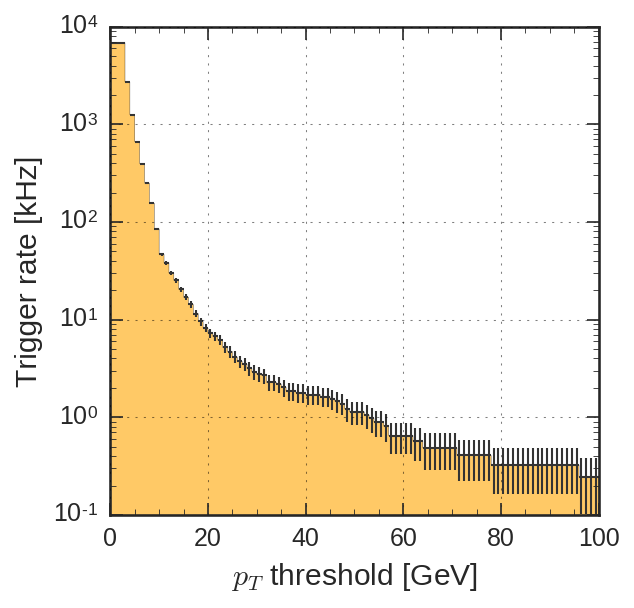

[INFO    ] Rates in kHz at 18/19/20/21/22 GeV: 9.5826087296, 8.20206347108, 7.2275609076, 6.74030959606, 6.17184972763


[6.8499e+03, 6.8499e+03, 6.8496e+03, 2.7176e+03, 1.2523e+03, 6.6291e+02,
 3.9597e+02, 2.5028e+02, 1.5576e+02, 8.5025e+01, 4.6614e+01, 3.8249e+01,
 3.0047e+01, 2.5256e+01, 2.0465e+01, 1.6973e+01, 1.4293e+01, 1.1532e+01,
 9.5826e+00, 8.2021e+00, 7.2276e+00, 6.7403e+00, 6.1718e+00, 5.1973e+00,
 4.7101e+00, 4.1416e+00, 3.7356e+00, 3.4920e+00, 3.1671e+00, 2.9235e+00,
 2.7611e+00, 2.6799e+00, 2.2738e+00, 2.2738e+00, 2.1926e+00, 2.0302e+00,
 1.8678e+00, 1.8678e+00, 1.7866e+00, 1.7866e+00, 1.7054e+00, 1.7054e+00,
 1.7054e+00, 1.6242e+00, 1.6242e+00, 1.5430e+00, 1.4618e+00, 1.3805e+00,
 1.2181e+00, 1.1369e+00, 1.1369e+00, 1.1369e+00, 1.0557e+00, 9.7450e-01,
 8.9329e-01, 8.9329e-01, 8.1209e-01, 6.4967e-01, 6.4967e-01, 6.4967e-01,
 6.4967e-01, 6.4967e-01, 5.6846e-01, 5.6846e-01, 4.8725e-01, 4.8725e-01,
 4.8725e-01, 4.8725e-01, 4.8725e-01, 4.8725e-01, 4.8725e-01, 4.0604e-01,
 4.0604e-01, 4.0604e-01, 4.0604e-01, 4.0604e-01, 4.0604e-01, 4.0604e-01,
 3.2483e-01, 3.2483e-01, 3.2483e-01, 3.2483e-01, 3.

In [34]:
# Rates
rates = np.concatenate((rates_array.reshape(-1), rates_array_last_job.reshape(-1)))
assert(len(rates) == rates_nevents)

# If the rates for a particular jobid is zero, assume the job has failed
rates_nevents_1 = 0
for jobid in xrange(rates_array.shape[0]):
  if rates_array[jobid].sum() > 0.:
    rates_nevents_1 += rates_nevents_per_job
if rates_array_last_job[0].sum() > 0.:
  rates_nevents_1 += rates_nevents_last_job
logger.info("nevents: {0}/{1}".format(rates_nevents_1, rates_nevents))  # should be half the statistics

expected_rates_nevents_1 = 258400
if rates_nevents_1 != expected_rates_nevents_1:
  logger.warning("rates_nevents_1 (which is {0}) != {1}, did some job fail?".format(rates_nevents_1, expected_rates_nevents_1))

def conversion_to_kHz(nevents):
  orbitFreq = 11246.
  nCollBunches = 2808
  nZeroBiasEvents = nevents
  convFactorToHz = orbitFreq * nCollBunches / nZeroBiasEvents
  return (convFactorToHz / 1000.)

rates = rates[rates > eps]
rates = np.clip(rates, 0., 100.)
w = conversion_to_kHz(rates_nevents_1)
weights = np.full_like(rates, w)

plt.figure()
hist, edges, _ = plt.hist(rates, bins=100, range=(0.,100.), cumulative=-1, weights=weights, histtype='stepfilled', facecolor='orange', edgecolor='k', alpha=0.6)
xdata = (edges[1:] + edges[:-1])/2
xerr = (edges[1:] - edges[:-1])/2
ydata = hist
sumw2 = (ydata/w)
yerr = w*np.sqrt(sumw2)
plt.errorbar(xdata, ydata, xerr=xerr, yerr=yerr, color='#333333', ecolor='#333333', fmt='none', capsize=0, lw=1)
plt.xlabel(r'$p_{T}$ threshold [GeV]')
plt.ylabel(r'Trigger rate [kHz]')
plt.xlim(0,100)
plt.ylim(1e-1,1e4)
plt.yscale('log')
plt.show()

logger.info("Rates in kHz at 18/19/20/21/22 GeV: {0}, {1}, {2}, {3}, {4}".format(hist[18], hist[19], hist[20], hist[21], hist[22]))
print np.array2string(hist, separator=', ', precision=4, floatmode='fixed')

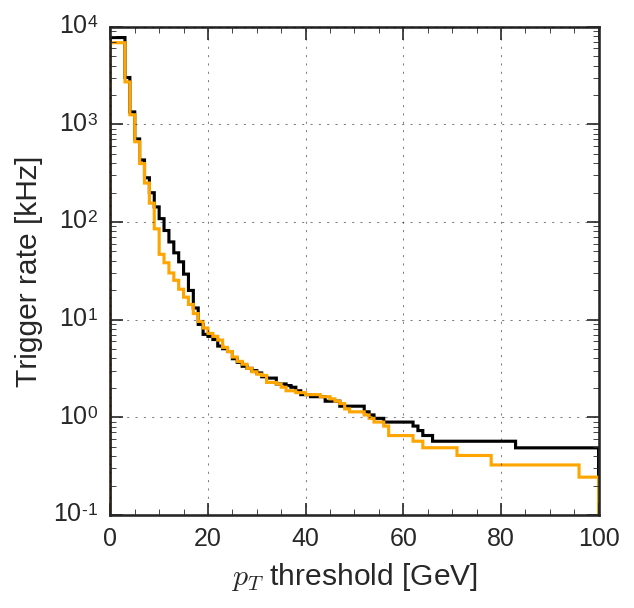

In [35]:
# Old rates
old_hist = [7.7367e+03, 7.7367e+03, 7.7367e+03, 3.0139e+03, 1.3394e+03, 7.0830e+02,
  4.3146e+02, 2.8350e+02, 1.9920e+02, 1.4260e+02, 1.0817e+02, 8.1777e+01,
  6.2449e+01, 4.8319e+01, 3.9061e+01, 2.9235e+01, 1.9896e+01, 1.3156e+01,
  8.9329e+00, 7.0651e+00, 6.7403e+00, 6.2531e+00, 5.3598e+00, 5.0349e+00,
  4.7101e+00, 3.9792e+00, 3.6544e+00, 3.3296e+00, 3.1671e+00, 3.0047e+00,
  2.8423e+00, 2.5987e+00, 2.5175e+00, 2.5175e+00, 2.1926e+00, 2.1926e+00,
  2.1114e+00, 2.0302e+00, 1.8678e+00, 1.7054e+00, 1.7054e+00, 1.6242e+00,
  1.6242e+00, 1.6242e+00, 1.4618e+00, 1.4618e+00, 1.4618e+00, 1.2993e+00,
  1.2993e+00, 1.2993e+00, 1.2993e+00, 1.2993e+00, 1.1369e+00, 1.0557e+00,
  9.7450e-01, 9.7450e-01, 8.9329e-01, 8.9329e-01, 8.9329e-01, 8.9329e-01,
  8.9329e-01, 8.9329e-01, 8.1209e-01, 7.3088e-01, 6.4967e-01, 6.4967e-01,
  5.6846e-01, 5.6846e-01, 5.6846e-01, 5.6846e-01, 5.6846e-01, 5.6846e-01,
  5.6846e-01, 5.6846e-01, 5.6846e-01, 5.6846e-01, 5.6846e-01, 5.6846e-01,
  5.6846e-01, 5.6846e-01, 5.6846e-01, 5.6846e-01, 5.6846e-01, 4.8725e-01,
  4.8725e-01, 4.8725e-01, 4.8725e-01, 4.8725e-01, 4.8725e-01, 4.8725e-01,
  4.8725e-01, 4.8725e-01, 4.8725e-01, 4.8725e-01, 4.8725e-01, 4.8725e-01,
  4.8725e-01, 4.8725e-01, 4.8725e-01, 4.8725e-01]
old_hist = np.array(old_hist, dtype=np.float32)

plt.figure()
centers = (edges[1:] + edges[:-1])/2
plt.hist(centers, weights=old_hist, bins=edges, histtype='step', color='k', lw=1.5)
plt.hist(centers, weights=hist, bins=edges, histtype='step', color='orange', lw=1.5)
plt.xlabel(r'$p_{T}$ threshold [GeV]')
plt.ylabel(r'Trigger rate [kHz]')
plt.xlim(0,100)
plt.ylim(1e-1,1e4)
plt.yscale('log')
plt.show()

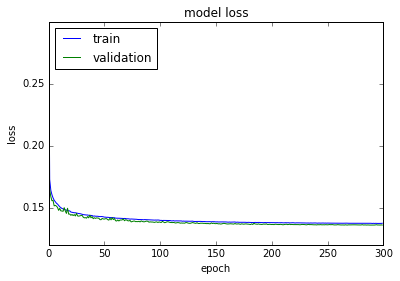

In [36]:
# Training history
# 2018-10-16

"""
[INFO    ] Done training. Time elapsed: 2:04:54.658612 sec
[INFO    ] Epoch 300/300 - loss: 0.137361058068 - regr_loss: 2.40064452563 - discr_loss: 0.0173288300487 - val_loss: 0.135927766511 - val_regr_loss: 2.37786404684 - val_discr_loss: 0.0170345622495
"""

from IPython.display import Image
Image(format="png", data="iVBORw0KGgoAAAANSUhEUgAAAZAAAAEZCAYAAAC5AHPcAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAIABJREFUeJzt3Xl8VfWd//HX5yY3ISvZIGFLCAOIQsWVUtwiVIvW1o5bVaijP7uMP1unTmfqMnWp/ro60+m0jrUupdrWUq1jteMCFUzVukBVoig7JGwhCWRPSHKT+/39cU4w0CDJIeGSm/fz8TiP3LPe7/ee5L7zPd+zmHMOERGR/grFugAiIjI0KUBERCQQBYiIiASiABERkUAUICIiEogCREREAlGAiBwGM1tkZnf1cdktZjb3cLcjcrRQgIiISCAKEBERCUQBInHPP3T0L2b2rpk1mtlDZjbazJ4zswYzW2pmI3ss/1kzW21mtWa23Mym9Zh3opm95a+3GBhxwHtdYGbvmFmdmb1qZh8LWOYvmdkGM9ttZn8wszE95v2nmVX5ZSgzs+P86eeb2ft+HbeZ2T8H/tBE+kABIsPFRcBc4BjgM8DzwM3AKCABuAHvS3gq8Jg/Pspf7o9mlmhmYeAp4BEgB3gCuLj7DczsROBh4Ev+/J8Dz/jr9ZnfT/Jd4BJgDLAVWOzPOxc4HZjsnBsJXAbs8Vd9CPiScy4TmAEsH+DPUGQ/ChAZLn7qnNvtnKsEXgHecM6965zr8EPhRH+5y4D/dc4td851Af/utzLmALOBROfcT5xzXc65J4GVPd7jS8D9zrm/Os+vgHZ/vf64EnjYOVfmnIsAtwCzzawQiAAZwHFmZs65dc65Kn+9DmC6mWU45xqcc6sG6LMT6ZUCRIaLqh6v9/Yynu6/HgtUdM9w3t1GtwPj/Hk7DthuRY/XRcA3/ENftWZWB4z31+uPA8vQAtQC45xzLwH3Av8NVJnZ/WbWXfaLgU8DFWb2kpn1N7hE+kUBIrK/nX4Q9DTBD45KPxB6KuzxehvwHedcjj9kO+fSnXO/O5wymFkakNsdXs65e51zpwDH+Yfk/tWf/pZz7nP+obengcf7W3mR/lCAiOzvceDTZna23+/xL0Ab8BrwOhAxs6/58y4CZvVY90HgH81sFv4Xv9+xndbPMvwWuMbMjjezZL8/5HXn3FYzO8XMZplZot9yagOiZhY2syvNLNM/9NYEdA3sRyOyPwWIDAcHPvTmoA/Bcc6tBxb6h4lq/ENCn3HOdfr9ERcB1/gd15cCT/ZY9y2/H+ReM6sF1gP/0Jf37TnPObcMuA34H7/VUQxc4c/O9IOqFtgC7Abu8ed9AdhiZvXAl/2+FJFBY3qglIiIBKEWiIiIBKIAERGRQBQgIiISiAJEREQCSYx1AQaCmelMABGRfnLO2eGsHzctEOdcXA533HFHzMug+ql+ql/8DQMhbgJERESOLAWIiIgEogA5ypWUlMS6CINK9RvaVL/hLS6uRPfuaj306yEicqSYGYfbiR4XZ2EdzMSJE6moqOjDknIkFRUVUV5eHutiiMhhiusWiJ+wMSmTHJz2i0jsDUQLRH0gIiISiAJEREQCUYCIiEggCpAh6rrrruM73/lOrIshIsOYOtFjpLi4mIcffpi5c+fGuihH3NG8X0SGC3Wix6muLj3KWkSOfgqQGLjqqqvYunUrF1xwAZmZmdxzzz2EQiF+8YtfUFRUxLx58wC47LLLGDNmDNnZ2ZSUlPDBBx/s28Y111zD7bffDsCf//xnJkyYwI9+9CPy8/MZN24cv/zlL2NWPxEZHhQgMfDoo49SWFjIs88+S2NjI5dddhkAL7/8MmvXrmXJkiUAnH/++WzatInq6mpOOukkFixYcNBt7tq1i6amJnbu3MlDDz3E9ddfT0NDwxGrk4gMP8M6QMwGZgiqZz+AmfHtb3+blJQUkpOTAbj66qtJTU0lHA5z++23U1ZWRlNTU6/bSkpK4rbbbiMhIYHzzjuP9PR01q1bF7xwIiKHMKwDxLmBGQbK+PHj972ORqPcfPPNTJ48maysLIqLizEzdu/e3eu6ubm5hEIf7s7U1FSam5sHrnAiIgcY1gESS9ZL06XntMcee4w//vGPLF++nPr6esrLywf0QTAiIodLARIjBQUFbN68GXo8TbGnpqYmkpOTyc7OpqWlhVtuuaXX0BERiRUFSIzcfPPN3H333eTk5PDkk0/+TThcddVVFBYWMm7cOGbMmMGcOXP6tX2FjYgMNl1IKEec9otI7OlCQhERiRkFiIiIBKIAERGRQBQgIiISiAJEREQCUYCIiEggChAREQlEASIiIoEoQIaQ7ud+dJsxYwYvv/xyn5btLz0yV0QOJTHWBZD+6XmLktWrV/d52Y/yyCOP8NBDD/HKK6/sm/azn/3sMEopIsOBWiCCc073zhKRflOAxMAPf/hDLr300v2mff3rX+frX/86v/zlLznuuOPIzMxk8uTJPPDAAwfdTnFxMcuXLwegra2Nq6++mpycHGbMmMHKlSv3W/YHP/gBkydPJjMzkxkzZvCHP/wBgLVr13Ldddfx+uuvk5GRQU5ODhzwyFyABx98kClTppCXl8fnPvc5Kisr980LhUL8/Oc/Z+rUqeTk5PDVr351gD4pETmaKUBi4PLLL+f555+npaUF/IdHPf7441x55ZXk5+fve9TtokWLuPHGG1m1atUht3nnnXeyZcsWtmzZwpIlS3jkkUf2mz958mT+8pe/0NjYyB133MHChQupqqpi2rRp3H///XziE5+gqamJ2trav9n28uXLufXWW/n9739PZWUlhYWFXH755fst8+yzz/LWW29RVlbG448/ztKlSw/7cxKRo9uw7gOxbw/MYRt3R//uLFtYWMhJJ53EU089xcKFC1m2bBlpaWnMmjVrv+XOOOMMzj33XF555RVOOOGEj9zmE088wf3338/IkSMZOXIkN9xwA3ffffe++RdffPG+15deeinf/e53WbFiBZ/5zGcOWd7HHnuMa6+9lpkzZwLwve99j+zsbLZu3UphYSEAt9xyCxkZGWRkZHD22WezatUqzj333H59LiIytAzrAOnvF/9AuuKKK/jtb3/LwoUL+e1vf8uVV14JwPPPP89dd93F+vXriUaj7N27l+OPP/6Q29u5c+d+j8QtKirab/6jjz7Kf/7nf1JeXg5AS0vLQR+P29u2Tz755H3jaWlp5ObmsmPHjn0Bkp+fv2++HqcrMjzoEFaMXHrppZSWlrJjxw6eeuopFixYQEdHB5dccgnf/OY3qampoa6ujvPOO69Pz84YM2YM27Zt2zdeUVGx7/XWrVv58pe/zH333UddXR11dXVMnz5933YP1YE+duzY/bbX0tLCnj179gssERl+FCAxkpeXx1lnncU111zDpEmTmDp1Kh0dHXR0dJCXl0coFOL555/vc1/CZZddxve+9z3q6+vZvn0799577755LS0thEIh8vLyiEajLFq0aL9TgPPz89m+fTuRSKTXbV9xxRUsWrSId999l/b2dm699VZmz559WNeZiMjQpwCJoSuvvJJly5axYMECANLT0/nJT37CpZdeSk5ODosXL+bCCy886Po9Ww533HEHhYWFFBcXM3/+fK666qp984499li+8Y1vMHv2bAoKCnj//fc5/fTT982fO3cu06dPp6CggNGjR//N+8ybN4+7776biy66iHHjxrFlyxYWL17cazl6GxeR+KRH2soRp/0iEnt6pK2IiMSMAkRERAJRgIiISCAKEBERCUQBIiIigShAREQkkLi+lUlRUZGuSTgKHXibFREZmuL6OhAREemdrgMREZGYUYCIiEggChAREQlEASIiIoEoQEREJBAFiIiIBKIAERGRQBQgIiISyKAHiJnNN7O1ZrbezG7qZf6VZlbmD6+a2fE95pX7098xsxWDXVYREem7Qb2ViZmFgHuBecBOYKWZPe2cW9tjsc3Amc65BjObDzwAzPbnRYES51zdYJZTRET6b7BbILOADc65CudcBFgM7PeQb+fcG865Bn/0DWBcj9mmw2wiIkenwf5yHgds6zG+/YCAONAXged7jDvgT2a20sy+NIjlFBGRfjpq7sZrZmcD1wCn95h8mnOu0sxG+UGyxjn3agyLKSIivsEOkB1AYY/x8f60/fgd5w8A83v2dzjnKv2fNWb2lH9IrNcAufPOO/e9LikpoaSkZMArIyIyVJWWllJaWjqg2xzU27mbWQKwzu9ErwRWAFc459b0WKYQWAZ8wTn3Ro/pqUDIOddsZmnAUuDbzrmlvbyPbucuItIPA3E790FtgTjnuszsq/6Xfwh42Dm3xsy+4s12DwC3ATnAfeY9/SninJsF5ANPmZnzy/mb3sJDRERiQw+UEhEZhvRAKRERiRkFiIiIBKIAERGRQBQgIiISiAJEREQCUYCIiEggChAREQlEASIiIoEoQEREJBAFiIiIBKIAERGRQBQgIiISiAJEREQCUYCIiEggChAREQlEASIiIoEoQEREJBAFiIiIBKIAERGRQBQgIiISiAJEREQCUYCIiEggChAREQlEASIiIoEoQEREJBAFiIiIBKIAERGRQBQgIiISiAJEREQCUYCIiEggChAREQlEASIiIoEoQEREJBAFiIiIBKIAERGRQBQgIiISiAJEREQCUYCIiEggfQoQM/snM8s0z8Nm9raZnTv4xRMRkaNVX1sg/8c51wicC2QDXwC+P8hlExGRo1hfA8T8n+cDv3LOvd9jmoiIDEN9DZC3zGypHyBLzCwDiA5y2URE5ChmzrlDL2QWAk4ANjvn6s0sBxjvnHv3iJTyEMzM9aUeIiLiMTOcc4d1JKmvLZBPAOv88FgIfAtoOJw3FhGRoa2vAfIzoNXMZgLfADYBjw5y2URE5CjW1wDp9I8RXQjc65z7byBjkMsmIiJHscQ+LtdkZrf4p++e4feJhAe5bCIichTrawvk80C7fz3ILmA8cM8gl01ERI5ifToLC6/HPh841R9d4ZyrHtSS9YPOwhIR6Z8jdhaWmV0GrAAuBS4D3jSzSw7njUVEZGjr63UgZcA53a0OMxsFvOicm3kkCnkoaoGIiPTPkbwOJHTAIas9upOviMjw1tezsF4wsyXAb/3xzwPPDWK5RETkKNenVoRz7l+BB4Dj/eEB59xNfVnXzOab2VozW29mf7OOmV1pZmX+8KqZHd/XdUVEJHb6fBZWoI1714usB+YBO4GVwOXOubU9lpkNrHHONZjZfOBO59zsvqzbYxvqAxER6YeB6AP5yENYZtYE9PbNbF7DxGUeYvuzgA3OuQp/e4v9q9n3hYBz7o0ey78BjOvruiIiEjsfGSDOucO9Xck4YFuP8e1+MBzMF4HnA64rIiJHUF870QedmZ0NXAOcHuuyiIjIoQ12gOwACnuMj/en7cfvOH8AmO+cq+vPut3uvPPOfa9LSkooKSkZoCqIiAx9paWllJaWDug2B7sTPQFY53eEV/pXs1/hnFvTY5lCYBnwhZ79IX1Zt8ey6kQXEemHQe9EP1zOuS4z+yqw1D9l+GHn3Boz+4rfCf8AcBuQA9xnZgZEnHOzDrbuYJZXRET6blBbIEeKWiAiIv1zJG9lIiIish8FiIiIBKIAERGRQOImQNQFIiJyZClAREQkkLgJkGg01iUQERleFCAiIhKIAkRERAJRgIiISCBxEyDqRBcRObLiJkDUAhERObIUICIiEogCREREAlGAiIhIIAoQEREJRAEiIiKBKEBERCSQuAkQXQciInJkxU2AqAUiInJkKUBERCQQBYiIiASiABERkUAUICIiEogCREREAombANFpvCIiR1bcBIhaICIiR5YCREREAlGAiIhIIAoQEREJJG4CpL091iUQERle4iZAqqpiXQIRkeElbgJk585Yl0BEZHiJmwDZsSPWJRARGV7iJkDUAhERObLiJkDUAhERObLiJkDUAhERObLiJkB2VHbFuggiIsNK3ARIw94mXQsiInIExU2AjJrQQGVlrEshIjJ8xE2A5I2vVUe6iMgRFDcBMrJ4I+vWxboUIiLDR9wESNbUDygtjXUpRESGj7gJkGjOGpYv15MJRUSOlLgJkO3tawDYuDHWJRERGR7iJkA27NlAydwuXnwx1iURERke4iZARqWNYs75W3j88ViXRERkeIibAJk+ajq5x73HqlW6L5aIyJEQNwFyVtFZvLp9ORdeCIsXx7o0IiLxL24C5Jy/O4c/bf4T//iP8NOfQiQS6xKJiMS3uAmQEwpOYM/ePeRN3Ujx5A5+85tYl0hEJL7FTYCELMQ5k87hmHuPIX/Bzdx6q27xLiIymMzFwZV3Zuacc9S31bN8y3L+/bV/Z/6O11i2DJYtg8TEWJdQROToYmY45+xwthE3LRCArBFZfHLSJymrKuObN0dIToZvfSvWpRIRiU+DHiBmNt/M1prZejO7qZf5x5jZa2bWZmb/fMC8cjMrM7N3zGxFX94vMzmTwpGFrKv9gF//Gp5+Gr72NYhGB7JWIiIyqAFiZiHgXuBTwHTgCjObdsBie4CvAff0sokoUOKcO9E5N6uv73vK2FNYuXMl6dmtvPEGvPUW3HXX4ddHREQ+NNgtkFnABudchXMuAiwGLuy5gHNut3PuLaCzl/UtSBlPGXMK1z93Pfn/ns8v1/wXTz0Fixahq9RFRAbQYHcvjwO29Rjf7odKXzngT2bWBTzgnHuwLyv9wwn/wKnjTmV02mgueOwCUsOpPP30lzjnHMjMhPnz+18RERHZ39HeiX6ac+4k4HzgejM7vS8rZY3IYs6EOUzOmcwzVzzDTS/exNgp1fzuyXa++EW47Tbo6oKVO1Zy67Jb961X2aRn4oqI9NVgt0B2AIU9xsf70/rEOVfp/6wxs6f81survS1755137ntdUlJCSUkJAFNzp/LZYz7Lg289yMPvPMy3n7iHxbdfzNSpkHPVIt5LWMStZ9xKyEJM+skkNt+wmTEZYw6nziIiR53S0lJKB/ipe4N6HYiZJQDrgHlAJbACuMI5t6aXZe8Amp1z/+GPpwIh51yzmaUBS4FvO+eW9rKu+6h6/Ln8z8x7dB4TRk4gPy2f1699g7/+1TH3j4W0Nqbyidb/x/zTx3DbljN49spnOX/K+QP/YYiIHEWO+utAnHNdwFf9L//3gcXOuTVm9hUz+zJeJfLNbBtwI/BvZrbVzNKBfOBVM3sHeAP4Y2/h0RdnFp3JRcdexJKFS6hpreG6Z/+RJXu/w5hRKfzokn+htfgJfv3Sm+CMr33nHb74RfjggwH/OERE4kpcXYneF+9WvcvSTUt5c8ebnFF4BguPX8jkn0zm2FHHkpYwktb6NM5rfoL77oP/+A/4+Mdh4kSww8ppEZGjy0C0QIZdgPTmxhdu5Mdv/phnLn+GG5fcyMYbNvLUU/DII7BihXdn32nTID0dTp0doeSMMLNnQ2rqgFZDROSIUYD4DjdAtjVs49pnruW5Bc+R9f0svv/J7/P56Z9nVNoonHPs3Gls3AjrqjfzT++fyvTS1axZOYasLDjhBDjnHPj0p2HKlAGtlojIoFGA+A43QHr6was/4LXtr7GjcQdZI7JIDacyt3guL25+kYlZE3m07FG+Pvvr/Nucu6iqgjffhKde3MGy50aSFk6nuBgKC2H8eEhKglNPhdCo9RSPHk3h6CySkwekmCIih0UB4hvIAMHr/OemF28iMzmTD2o+YNWuVUzKnsTzG5/n+QXPs/B/FvKtM7/F2t1rWbZlGTubdnLcqOksOu0v7NiewNat3mN1W1odb7wBr584g4Tyc+j83x/zsY/Bl74Ee/bAjBmQkQHJyVBcDGPHqq9FRI4MBYhvoAOkJ+ccURelrbONl8pf4oKpF7B49WJKy0uZkjOFucVz+Vj+xyj5ZQkXHXsR//wJ736Qe1r3MOcXc7ho2kX85r3f0BJp4YZZ/8RbZXsZ+dfvMWaMd6bX3r3esGkTdHRAKOSNjx4Ns2bB2WdDbi4UFXnhMmqU17oJhweluiIyTChAfIMZIH21bvc6zn/sfPLT8umMdhJOCJOXmscLG1/gh5/8IcvLl7O6ejWN7Y384JM/oLS8lIuPvZiXyl8ie0Q2U3KncFru50hJTCUlxbFjZ5Q3Xk/glVegvh4qKrz3qa6GyuadZKQmExq7isjkJylafR+5eVEuvijE2LEwYoTXqklO9jr+R46E7GyvtdPeDikpaumIDHcKEN/RECAATe1NvFzxMkkJSSzbsow7zrqDDbUbOCb3GOrb6jEzFr2ziO+88h2+NutrLN28lAumXEAkGuGVra+Qk5LDk5c9yY0v3Mjv3v8dV828ipCFWL5lOZFohB9/6secXng6pz44iyRLpaWjhc0NG/jshKtZsu33fGrT++ytzaG93QuKtjZoafECaHdnBa0TniZ51Q0AnHQSpKV5oXLccV7LpqHBu1fYyJH7DxMneq0ghY5I/FCA+I6WAOmLrmgXu1t3k5+ev9/0jq4O5j06jy11W8hOyeb+T9/Psi3L6Ip2MW/SPPa07uEr//sVThl7Cg3tDYQsRHNHM3eedSfXPXsdMwtmcurYU7nr7Lv4VdmvmDNhDjWtNZSWl9LS0cKiVYto72rnnnPuoXTTX4g2juG8UdcRbhvD26s6qat35GaFaWrygqShARoboa4ONm/2xpOSvCE52QueggLYutWblpHhDZmZf/s6M9MLq5YWb92WFu8pkdOmwfTp3vp5edDc7B3CS0z0DtGFw964gktk4ClAfEMpQD5KZ7STTbWbGJsxlozkjL+Zv61hG7945xdcctwljE4bTUukhYlZE+mKdlHRUMEpD5zCmUVn8nbl23R0dRB1Ua6aeRXpSenMLZ5LW2cbn/r1p7hh1g04HItXL6ZkYgmvbXuNY0cdywsLXmBX8y7+tPlPtEZauWLGFWSnZAOws3EXCS6F9TWbWbZ5GRdO+DJNNZkUFcHWhgpe3foXUroKmJRwBntbwjQ2QlOTNzQ2eqGRlua1itLSoLMT3nsP1q/3Wks1u6NkZng3RohEvKGz03sQWDjshVVJidc/tG2b1z/U0eGNdwdOYqI3ZGR4JyjU1np9Sd0B1B2A3f1HjY3ee5900ocnMHR2ejfaBO9nZ6d3+C8p6Uj9FogcGQoQX7wEyOFaXb2aJRuX8IWZX2DVrlWMzxzPcaOO22+Z8vpyJmZNBGDDng2s3LmSqblT+cbSb1DdUk1VcxWfmvwpAJ7b8ByGkRpOZW/nXsIh75v3tMLTWLZ5GTMLZtLW2UZ5fTlnFp1JeX05AH8/7e+pbKokPz2fpIQkjsk9hsKRhbyy9RXK68uZVzyPhvYGdjbt5Pwp5/Pi5he56cWb+L+n/F9uP+t2Oro6uHfFvby9620K0sbwmcl/T2F0LqtWppCaCqPyI6x8M0xGhtfH0x023UNtLaxe7R12q6nxgsHMC4uODm958FpGCQneA8eqq71pPVs9oZA3v77e61cy8wKtoMALFfyw6+jwtpWS4rXYEhK8i0yLi70WV0eHF2TRqBdK3UNCwv6hN2aMt3xtrVf2SOTDkyyamz88Pby2FnJyvDKEerkZUXKyN6+77N2HJUeM8KYBtLZ6283I+DAowfs8e7b4uv+s1AqMPwoQnwLk8O1p3cPKnSs5e+LZJCd6F6vsbt1NyEK0dLQwOm00m+o20RXt4mP5H6N2by1lu8pICCUwe/xskhKScM7x0NsPsWb3GopGFlHTWkN7Zztrdq9hS/0W5oyfw5TcKTz23mOkJ6UzfdR0Xip/iZRwCg9/9mEeevshHnvvMQAWHr+Q8yafx8bajfzP2v/hze1vErIQSQlJtEZaOSbvGM4oPINNdZvYsGcDyYnJnFhwImcVnUVNaw25Kbl0uS5GJI7gobcfYmfTTj4+/uNcPv1yJmZNZGfTTv6w7g/8ufzPzBg9g7Mnns2JY07kmXXPkBhK5JunfRPnHGVVZXRFo3S0JTI+o5DEUCJdjaOJtHq3Iehu/WzdU8OTWx7is393CbvbqshlKnu2jqajw5GUBLt3GwkJ7DfsjmwlHM0ksTOLxkbYtcv7Us/N9UIiHPZCKSXFa7WtW+cFYm6uF1T19R9+wffU1ubNi0QgK8trBdbXe9MTEiAps55oJImUxFSamj4MMee8MElJ+fCwZG2tF4CjRnnb6Rl6PV93D11d+wdmd39cXp43rbnZO4U9NdV7j/Z2r/UXjXotwsZGLwCLirw6dwd796HNnoc3u1udI0Z82KqNRr2wrK72tpOS4n2mbW3edvLzvfDds8cLxZQU73Pq/hyysrzWcna2Ny0U+vCwbUKCN95z6P5Ho7dpznmfRXu79x6pqd5n2tsZlAcGdG+BfahlMjO9Yc8e7/NuaPDeKy3NK0806g1NTV65jj9eAQIKkLhS3VJN9ohswgn7/5U552jvaqets430pHTKdpXxytZXmJg1kePzj6e9s53S8lJW7FzB2PSx1O6tJSGUQH1bPZ+b9jlmjZvFcxue44WNL7CtcRs5KTlcMOUC5k2ax/vV7/NS+UuUVZVx6thTae5o5okPnsAwThxzIkkJSUS6IlQ0VNAV7aKmtYbUcKp3tl0ozLGjjmXd7nWcWXQmSzYtYVL2JCrqK8hOyWZ3627Sk9KZPX427Z3tzMyfSXVLNaUVpTS1N7G3cy/5afmcPPZkirOK2RvZy66WXdTurSU3JZcx6WPIS83jyTVPErIQ8yfPp6WjhaqWKmbmz6Q4u5jlW5aTNSKLaXnT2N26m4r6CkYkjmBi1kRyUnKYljeN7JRsfrbyfk7IP5lvvXQLkWgH1554LROzJpIaTuXtyrc5vfB0Ribmk5s0joq6Hfx1+zuMTEumzTVRsbuKa0/8IuHQCLY3bCcjMZe85LG0treT4EZQ01pDecNG8lIKGJsxhpa6dJxFqO7czLjMsbTUZrBnD4RHdNCWtp7aliYmhmdBuJW/lq+hKHU6WSONrIwwkfYwFRXeF3lBgfdF2d1qi0SguaOFjkiUhM4MOjs/PFkkIdHRHqqlrS6H0aOMSMT78h4xwgsK57yQ7v6CBS9cwmHviz0S8YI2Lc0L6MxMb53uEOzq8sa7v4jYknC0AAAJiElEQVS7h4NNw28NJiV54dTa6n15dx8i/fB3+6PH+7pMXZ0XwLm5Xh2zsrw6tbR4y3cHXFoafPKTcP/9ChBQgMggcc5hvfwr2BntpL6tnpCF2BvZy4baDYzPHM/knMn71mnuaN4XhlUtVZTtKiMpIYn3qt9jVOooTi88nRmjZxB1UdbtWcdbO99iW+M2UhJTKEgvIDslmz2te6hsrqSquYozis4gHAqzYscKUsIpjE4bTdmuMtbXrqekqIT2rnbW7l5L9ohsJudMpiXSwraGbezZu4c1u9ewtWErV8y4gpfKX+LqmVdzWuFpLNm4hM31m6nbW8fJY07mzR1vUtdWx7aGbYzJGMOJBSfSGmklnBAmMymTxz/wngk9LmMctXtrqWqp2ndYMzkxmWl506huqaayqZKoi9IZ7aRwZCHVLdX7DptuqttE0cgiwglhNtZuBGByzmS21G2hy3XhnCM9KR0zI2QhDO9nYiiR/PR8Oro62FS7CYdjb2Qv6UnpTM2dSm5qLmW7ymjuaCY1nEpSQhKJoURyUnLITskmOSGZqItSkF5AeX05Xa4Lw6hprWF02mjSwmns7dxLajiVyqZKMpIzSAunUdNaw47GHeSl5tHe1U6kK8K0vGlMyJyAw9EaaWXN7jWkhlMpSC+gIK2AEYkjiEQjhENhEkOJbKzbSHFWManhVDbVbQIgHArT0dVBR1cHndFOzIwES2BE4oh95Q+HwiQlJLG5fjPVLdWcPOZkuqJddEY7GZU2iuaOZhJDiWSNyCI5IRmHd81a93VrFfUVbG3cyrTcaaSGU0kJpxDpitDY3sjHx3+cBccvUICgABGJia5oFyEL0RppJSHkffnhB+/ezr0kJySTEEog0hVhdfVqzIxpedP2LdfU3rQvLJram0gJp9AV7aKxvRGH23cRr8PR0dXBruZdJCUkMS1vGimJKURdlIb2Bjbs2UBNaw3H5x/PhMwJbG/cDn7Q1+6tpa6tjvbOdgAqmyuZmDVxX6Dkpuays2knbZ1tpIa9U+PHZY6juaOZpvYmRqeNZmzGWKpbqklOTCYpIYl1u9exvXE7CaEEkhOSOSbvGNo726lqqWJX8y7aOtsIh8L7WsxTcqawtWErrZFWJmVPImQhOqOdJCUkkZyYTIIl4HB0Rbto62yjNdJKR1cHkWiESFeEgvQCRqeNZnX1apISkghZiOqWajKSM+iKdlHXVkdHVwchC+0bwqEwRVlFjMsYxwc1H9AZ7aQl0kJiKJGRySNJCadw/azrFSAoQERE+u2of6CUiIjELwWIiIgEogAREZFAFCAiIhKIAkRERAJRgIiISCAKEBERCUQBIiIigShAREQkEAWIiIgEogAREZFAFCAiIhKIAkRERAJRgIiISCAKkKNcaWlprIswqFS/oU31G94UIEe5eP8FVv2GNtVveFOAiIhIIAoQEREJJG4eaRvrMoiIDDV6JrqIiMSEDmGJiEggChAREQlkSAeImc03s7Vmtt7Mbop1eQaCmZWbWZmZvWNmK/xp2Wa21MzWmdkSMxsZ63L2lZk9bGZVZvZuj2kHrY+Z3WJmG8xsjZmdG7OC99FB6neHmW03s7f9YX6PeUOmfmY23syWm9n7Zvaemd1AHO2/Xur3NeJr/yWb2Zv+d8n7ZvZdBnr/OeeG5OCH30agCAgDq4BpsS7XANRrM5B9wLQfAN/0X98EfD/W5exHfU4HTgDePVR9gOOAd4BEYKK/fy3WdQhQvzuAf+5l2WOHUv2AAuAE/3U6sA6YFi/77yPqFxf7zy9zqv8zAXgDOG0g999QboHMAjY45yqccxFgMXBhrAs1AKyXluGFwCP+60eAz8WgXIE4514F6g6YfLD6fBZY7JzrdM6VAxv8/XzUOkj98PfjgS4cSvVzzu1yzq3yXzcDa4Dx8bL/DlK/cf7sIb//8OrV6r9M9r9X6gZy/w3lABkHbOsxvr3Hzh/KHPAnM1tpZl/0p+U756rwf+mB0bEt4mEbfZD6HLhPdwzhffpVM1tlZg/1OEQwZOtnZhP9ltYbH/H7GA/1e9OfFBf7z8xCZvYOsAsodc59MJD7bygHSLw6zTl3EnA+cL2ZneGHSk/xdu51vNXnPmCSc+4E/w/3P2JdoMNhZunA74F/8v9Tj6vfx17qFzf7zzkXdc6d6LcczzCzkoHcf0M5QHYAhT3Gx/vThjTnXKX/swb4g9+ErDKzfLxf9gKgOtblPEwHq88OYEKP5YbkPnXO1Ti37wKrB3scBhhy9TOzRP/L9VfOuaf9yXGz/3qrXzztv27OuUbgOeCUgdx/QzlAVgKTzazIzJKAy4FnYl2ow2Fmqf5/Q5hZGnAu8J5fr6v9xf4BePqjt3TUsQOOKR+sPs8Al5tZkpkVA5OBFTEob3/tVz//j7LbRcBq//VQrN8vgA+cc//VY1o87b+/qV+87D8zy+s+/GZmKcA5fif5wO2/WJ8lcJhnGMz3z5zYANwc6/IMQH2K/bPJ3vGD42Z/eg7wol/XpUBWrMvajzo9BuwE2oGtwDVA9sHqA9zin/2xBjg31uUPWL9HgXf9ffkH/5jzkKuff8ZOV4/fybf9v7mD/j7GSf3iZf99zK/TO0AZ8C/uEN8n/a2fbmUiIiKBDOVDWCIiEkMKEBERCUQBIiIigShAREQkEAWIiIgEogAREZFAFCAiMWRmZ5nZH2NdDpEgFCAisaeLsWRIUoCI9IGZLfAfzvO2mf3Mv8tpk5n9yMxWm9mfzCzXX/YEM3vdv5vrkz1uJ/F3/nKrzOyv/u0iADLM7An/IT6/imlFRfpBASJyCGY2Dfg8MMe/U3IUWACkAiucczOAl/0HEeE/Y+Ff/bu5ru4x/TfAT/3pc4BKf/oJwA3+A33+zszmxKiqIv2SGOsCiAwB84CTgJVmZsAIoMoPksf9ZX4NPGlmmcBI/0FT+GHyuH+TzHHOuWfw7kHXgRdO+CFU6Y+v8p8G91qM6irSZwoQkUMz4BHn3L/tN9HstgOWcz2W74/2Hq+79HcpQ4UOYYkc2jLgEjMbhRcc2WZW6D9n+hJ/mQXAq/5zF2rN7DR/+heAP/sPKtpmZhf620jyb7EtMmTpPx2RQ3DOrTGzbwFLzSwEdABfBVqAWX5LpMrvJ8F/xsLP/YDY7N/iHT9MHjCzu/xtXNrb2x3BqokcFt3OXSQgM2tyzmXEuhwisaJDWCLB6b8vGdbUAhERkUDUAhERkUAUICIiEogCREREAlGAiIhIIAoQEREJRAEiIiKB/H8LC1I3XjGV+gAAAABJRU5ErkJggg==")

In [37]:
if False:
  import nn_encode
  reload(nn_encode)
  import nn_data
  reload(nn_data)
  from nn_encode import Encoder
  from nn_data import muon_data_split

  adjust_scale = 0
  reg_pt_scale = 1.0
  correct_for_eta = True
  
  x_train, x_test, y_train, y_test, w_train, w_test, x_mask_train, x_mask_test = \
    muon_data_split(infile_muon, adjust_scale=adjust_scale, reg_pt_scale=reg_pt_scale, test_size=0.5, correct_for_eta=correct_for_eta)

  if not isinstance(y_train, list):
    y_train = [y_train]

In [38]:
if False:
  print x_train.shape, y_train[0].shape, x_mask_train.shape
  #print np.mean(y_train[0]), np.std(y_train[0]), np.percentile(y_train[0], [2,98])
  
  fig, axs = plt.subplots(80/4, 4, figsize=(4*4,4*80/4), tight_layout=True)

  for i in xrange(x_train.shape[1]):
    lay = (i % nlayers)
    mask = x_mask_train[...,lay].copy()
    if i >= (nlayers*6):
      mask *= False
    
    valid = ~mask
    x_i = x_train[valid,i]
    y_i = y_train[0][valid]/reg_pt_scale

    xmin, xmax = -2, 2
    ymin, ymax = -0.6, 0.6
    if (nlayers) <= i < (nlayers*2):
      xmin, xmax = -3, 3
    if adjust_scale == 0:
      _range = None
    else:
      _range = [[xmin, xmax], [ymin, ymax]]
    
    hist = axs[(i/4, i%4)].hist2d(x_i, y_i, bins=40, range=_range, cmap=plt.cm.viridis)
    if x_i.size > 0:
      print i, x_i.size, np.mean(x_i), np.std(x_i), np.percentile(x_i, [2,98])

In [39]:
if False:
  from sklearn.linear_model import LinearRegression
  from sklearn.covariance import EmpiricalCovariance, MinCovDet

  print x_train.shape, y_train[0].shape, x_mask_train.shape

  #fig, axs = plt.subplots(80/4, 4, figsize=(4*4,4*80/4), tight_layout=True)
  
  coefs = np.ones((nlayers * 7) + 3)
  
  y_train_stdev = np.std(y_train[0]/reg_pt_scale)

  for i in xrange(x_train.shape[1]):
    lay = (i % nlayers)
    mask = x_mask_train[...,lay].copy()
    if i >= (nlayers*6):
      mask *= False
    
    valid = ~mask
    valid = valid & (np.abs(1.0/y_train[0]) < discr_pt_cut/reg_pt_scale)  # skip high pT part
    x_i = x_train[valid,i].copy()
    y_i = (y_train[0][valid]/reg_pt_scale).copy()
    assert(np.isfinite(x_i).all())
    
    nentries_test = 120000
    x_i = x_i[:nentries_test]
    y_i = y_i[:nentries_test]
    y_i /= y_train_stdev
    #y_i /= (1.0/np.sqrt(12))  # stdev: (b-a)/sqrt(12)
    
    if x_i.size > 0 and np.std(x_i) > 0.:
      coef = 1.0
      
      # x_phi
      if (i < nlayers):
        mcd = MinCovDet(assume_centered=True).fit(np.column_stack((x_i,y_i)))
        coef = mcd.covariance_[0,1] / mcd.covariance_[0,0]  # Cov[x,y]/Var[x]
        print i, coef, np.std(x_i), np.std(x_i * coef), np.std(y_i)
        
        #lr = LinearRegression(fit_intercept=False).fit(x_i[:,np.newaxis], y_i)
        #coef = lr.coef_[0]
        #print i, coef, np.std(x_i), np.std(x_i * coef), np.std(y_i)
      
      # x_theta
      elif (nlayers) <= i < (nlayers*2):
        coef = 1.0/np.std(x_i)
        print i, coef, np.std(x_i), np.std(x_i * coef), np.std(y_i)
      
      # x_bend
      elif (nlayers*2) <= i < (nlayers*3):
        if lay in (0,1,2,3,4) or lay in (9,10,11,):  # ME1/1, ME1/2, ME2, ME3, ME4, GE1/1, GE2/1, ME0
          mcd = MinCovDet(assume_centered=True).fit(np.column_stack((x_i,y_i)))
          coef = mcd.covariance_[0,1] / mcd.covariance_[0,0]  # Cov[x,y]/Var[x]
        elif lay in (5,6):  # RE1, RE2
          coef = 1.0/np.std(x_i)
        else:  # RE3, RE4
          coef = -1.0/np.std(x_i)
        print i, coef, np.std(x_i), np.std(x_i * coef), np.std(y_i)
      
      coefs[i] = coef

  print np.array2string(coefs, separator=', ', precision=6, floatmode='fixed')

In [40]:
if False:
  with np.load(infile_muon) as loaded:
    the_variables = loaded['variables']
    the_parameters = loaded['parameters']

  from nn_encode import Encoder
  encoder = Encoder(the_variables, the_parameters, adjust_scale=adjust_scale, reg_pt_scale=reg_pt_scale)
  x, x_mask, y_pt, y_eta = encoder.get_x(), encoder.get_x_mask(), encoder.y_pt.copy(), encoder.y_eta.copy()

  y_pt_cut = (np.abs(1.0/y_pt) > discr_pt_cut/reg_pt_scale)  # select high pT part
  x, x_mask, y_pt, y_eta = x[y_pt_cut], x_mask[y_pt_cut], y_pt[y_pt_cut], y_eta[y_pt_cut]
  
  nentries_test = 120000 * 2
  x, x_mask, y_pt, y_eta = x[:nentries_test], x_mask[:nentries_test], y_pt[:nentries_test], y_eta[:nentries_test]

In [41]:
if False:
  fig, axs = plt.subplots(12/4, 4, figsize=(4*4,4*12/4), tight_layout=True)
  
  for i in xrange(12):
    mask = x_mask[...,i].copy()
    
    valid = ~mask  # valid hits
    
    denom_hist, edges = np.histogram(np.abs(y_eta), bins=70, range=(1.1,2.5))
    num_hist, edges = np.histogram(np.abs(y_eta)[valid], bins=70, range=(1.1,2.5))
    eff_hist = np.true_divide(num_hist, denom_hist)
    
    xdata = (edges[1:] + edges[:-1])/2
    ydata = eff_hist
    
    xmin, xmax = 1.2, 2.5
    ymin, ymax = 0, 1.05
    
    axs[i/4,i%4].errorbar(xdata, ydata, color='b', marker=',', capsize=0, lw=1)
    for x in [1.24, 1.55, 1.7, 1.8, 1.98, 2.15, 2.4]:  # vertical lines
      axs[i/4,i%4].plot([x,x], [ymin,ymax], '--', color='grey')
    for y in [0.95]:  # horizontal lines
      axs[i/4,i%4].plot([xmin,xmax], [y,y], '--', color='grey')
    axs[i/4,i%4].set_xlim(xmin,xmax)
    axs[i/4,i%4].set_ylim(ymin,ymax)
  
  plt.show()

In [42]:
if False:
  # Check loss functions
  from keras.losses import mean_squared_error, mean_absolute_error
  
  def huber_loss(y_true, y_pred, delta=1.345):
    x = K.abs(y_true - y_pred)
    squared_loss = 0.5*K.square(x)
    absolute_loss = delta * (x - 0.5*delta)
    xx = tf.where(x < delta, squared_loss, absolute_loss)  # needed for tensorflow
    return K.mean(xx, axis=-1)
  
  def asymmetric_huber_loss(y_true, y_pred, delta=1.345):
    x = K.abs(y_true - y_pred)
    squared_loss = 0.5*K.square(x)
    absolute_loss = delta * (x - 0.5*delta)
    x2 = K.abs(y_true) - K.abs(y_pred)  # x2 >= 0: underprediction of 1/pT -> overprediction of pT
    xx = tf.where(tf.logical_or(x < delta, x2 >= 0), squared_loss, absolute_loss)  # needed for tensorflow
    return K.mean(xx, axis=-1)

  nentries_test = x_test.shape[0]//100

  # Prepare y_test_true, y_test_meas
  y_test_true = y_test
  if isinstance(y_test_true, list):
    y_test_true = y_test_true[0]
  y_test_true = y_test_true[:nentries_test].copy()
  y_test_true = y_test_true.reshape(-1)
  #y_test_true /= reg_pt_scale

  y_test_meas = loaded_model.predict(x_test[:nentries_test], batch_size=4096)
  if isinstance(y_test_meas, list):
    y_test_meas = y_test_meas[0]
  y_test_meas = y_test_meas.reshape(-1)
  #y_test_meas /= reg_pt_scale
  
  sess = K.get_session()
  diff = y_test_true - y_test_meas
  mask = np.abs(y_test_true) - np.abs(y_test_meas) > 0.
  
  loss1 = mean_squared_error(y_test_true[:,np.newaxis], y_test_meas[:,np.newaxis]).eval(session=sess)
  loss2 = mean_absolute_error(y_test_true[:,np.newaxis], y_test_meas[:,np.newaxis]).eval(session=sess)
  loss3 = huber_loss(y_test_true[:,np.newaxis], y_test_meas[:,np.newaxis]).eval(session=sess)
  loss4 = asymmetric_huber_loss(y_test_true[:,np.newaxis], y_test_meas[:,np.newaxis]).eval(session=sess)
  
  plt.figure()
  #plt.scatter(diff, loss1, c='r', s=2, edgecolors='none')
  #plt.scatter(diff, loss2, c='g', s=2, edgecolors='none')
  #plt.scatter(diff, loss3, c='b', s=2, edgecolors='none')
  plt.scatter(diff[mask], loss4[mask], c='magenta', s=2, edgecolors='none')
  plt.scatter(diff[~mask], loss4[~mask], c='cyan', s=2, edgecolors='none')
  #plt.legend(['mse', 'mae', 'huber', 'asym huber #1', 'asym huber #2'])
  plt.xlim(-5,5)
  plt.ylim(-1,11)
  plt.show()
  
  print y_test_true.shape, y_test_true, y_test_meas, diff, np.percentile(diff, [25,50,75], overwrite_input=True)

In [43]:
if False:
  # Tensorflow Interface for CMSSW
  # https://github.com/riga/CMSSW-DNN#keras
  
  import tensorflow as tf
  #sess = tf.Session()

  from keras import backend as K
  #K.set_session(sess)
  sess = K.get_session()

  # save at as a constant graph
  ## names found with: [node.op.name for node in loaded_model.outputs]
  ## to get all nodes: [n.name for n in tf.get_default_graph().as_graph_def().node]
  #outputs = [u'regr/BiasAdd', u'discr/Sigmoid']
  outputs = [u'dense_7_1/BiasAdd']
  constant_graph = tf.graph_util.convert_variables_to_constants(
      sess, sess.graph.as_graph_def(), outputs)
  tf.train.write_graph(constant_graph, "/tmp/jiafu", "constantgraph.pb", as_text=False)

  # save it as a SavedModel
  builder = tf.saved_model.builder.SavedModelBuilder("/tmp/jiafu/simplegraph")
  builder.add_meta_graph_and_variables(sess, [tf.saved_model.tag_constants.SERVING])
  builder.save()